In [1]:
import os

model_root = '../results/models'
files = os.listdir(model_root)
params = ['_'.join(f.split('_')[2:]) for f in files]
params = [p.split('.pkl')[0] for p in params]
params = list(set(params))
params

['p_19.0_q_9.122152261131532_g_1',
 'p_7.305688086564288_q_7.517332462471247_g_2',
 'p_0.5_q_1.895944090041435_g_1',
 'p_19.0_q_8.483911078685804_g_2',
 'p_5.5_q_9.010757520712524_g_1']

In [2]:
import pandas as pd
import pickle

for p in params:
    emb_fp = f'../data/emb/from_adelle/emb_{p}.tsv'
    emb = pd.read_csv(emb_fp, sep='\t', index_col=0)
    samples = emb[emb.index.str.startswith('MD')]
    end_samples = samples[samples.index.str.contains('End')]
    features = emb[~emb.index.str.startswith('MD')]
    for classifier_type, colnames in zip(['time', 'diet'], [['baseline', 'endpoint'], ['dairy', 'meat']]):
        for model_num in range(1,6):
            model_fp = f'{model_root}/{classifier_type}_{model_num}_{p}.pkl'
            if not os.path.exists(model_fp):
                continue
            with open(model_fp, 'rb') as f:
                model = pickle.load(f)
            feature_preds = model.predict_proba(features)
            feature_preds = pd.DataFrame(feature_preds, index=features.index, columns=colnames)
            if classifier_type == 'time':
                sample_preds = model.predict_proba(samples)
                sample_preds = pd.DataFrame(sample_preds, index=samples.index, columns=colnames)

            else:
                sample_preds = model.predict_proba(end_samples)
                sample_preds = pd.DataFrame(sample_preds, index=end_samples.index, columns=colnames)

            #feature_preds.to_csv(f'/mnt/home/f0106093/Projects/multiomics-embedding/results/predictions/{classifier_type}_{model_num}_{p}_features.tsv', sep='\t')
            #sample_preds.to_csv(f'/mnt/home/f0106093/Projects/multiomics-embedding/results/predictions/{classifier_type}_{model_num}_{p}_samples.tsv', sep='\t')

/mnt/home/f0106093/anaconda3/envs/multiomics/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/f0106093/anaconda3/envs/multiomics/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/mnt/home/f0106093/anaconda3/envs/multiomics/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/mnt/home/f0106093/anaconda3/envs/multiomics/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegre

In [3]:
root = '../results/predictions'

def get_predictions(file):
    if os.path.exists(file):
        df = pd.read_csv(file, sep='\t', index_col=0)
        return df[df.columns[0]].to_list()

diet_features = {}
time_features = {}
diet_samples = {}
time_samples = {}

for p in params:
    diet_features[p] = {}
    time_features[p] = {}
    diet_samples[p] = {}
    time_samples[p] = {}
    for model_num in range(1,6):
        diet_features[p][model_num] = get_predictions(f'{root}/diet_{model_num}_{p}_features.tsv')
        time_features[p][model_num] = get_predictions(f'{root}/time_{model_num}_{p}_features.tsv')
        diet_samples[p][model_num] = get_predictions(f'{root}/diet_{model_num}_{p}_samples.tsv')
        time_samples[p][model_num] = get_predictions(f'{root}/time_{model_num}_{p}_samples.tsv')




({'p_19.0_q_9.122152261131532_g_1': 0.653481920240584,
  'p_7.305688086564288_q_7.517332462471247_g_2': 0.7792003858707375,
  'p_0.5_q_1.895944090041435_g_1': 0.7646597297904117,
  'p_19.0_q_8.483911078685804_g_2': 0.7472491831585011,
  'p_5.5_q_9.010757520712524_g_1': 0.8357891133074661},
 {'p_19.0_q_9.122152261131532_g_1': 0.9039593993680175,
  'p_7.305688086564288_q_7.517332462471247_g_2': 0.789732362249872,
  'p_0.5_q_1.895944090041435_g_1': 0.799466252079905,
  'p_19.0_q_8.483911078685804_g_2': 0.9067436663530135,
  'p_5.5_q_9.010757520712524_g_1': 0.6789837783534146},
 {'p_19.0_q_9.122152261131532_g_1': 0.8408947323486723,
  'p_7.305688086564288_q_7.517332462471247_g_2': 0.8792879706309229,
  'p_0.5_q_1.895944090041435_g_1': 0.8876462050712883,
  'p_19.0_q_8.483911078685804_g_2': 0.8997950994621361,
  'p_5.5_q_9.010757520712524_g_1': 0.918483736019807},
 {'p_19.0_q_9.122152261131532_g_1': 0.9410592160133445,
  'p_7.305688086564288_q_7.517332462471247_g_2': 0.9136474840144565,
  '

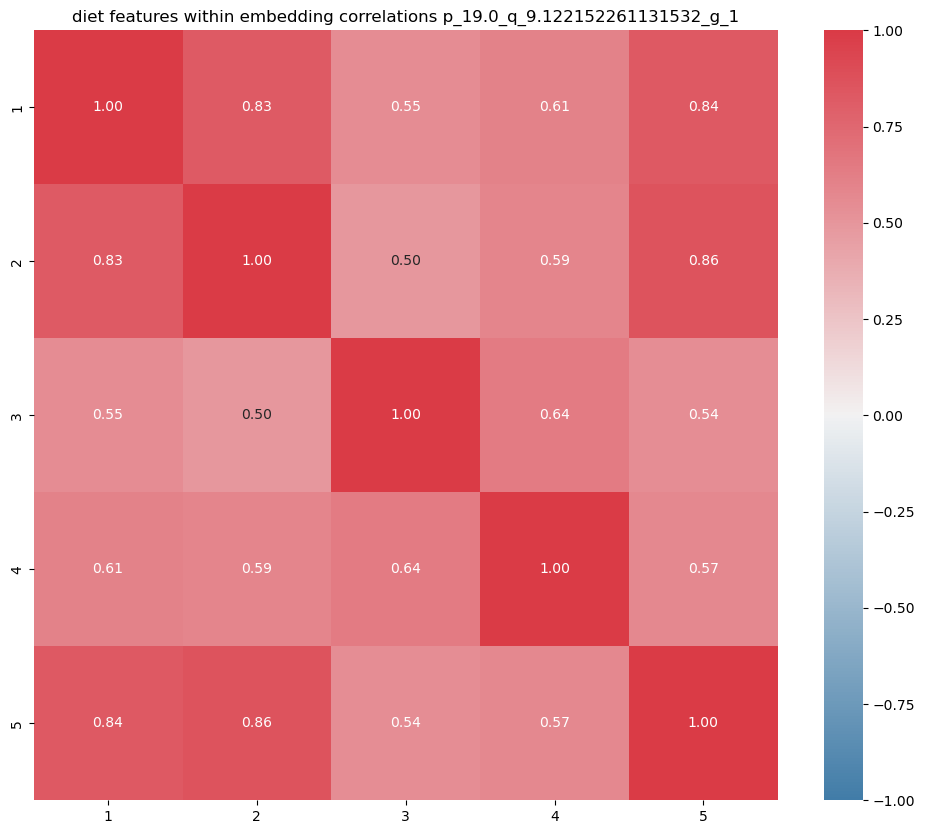

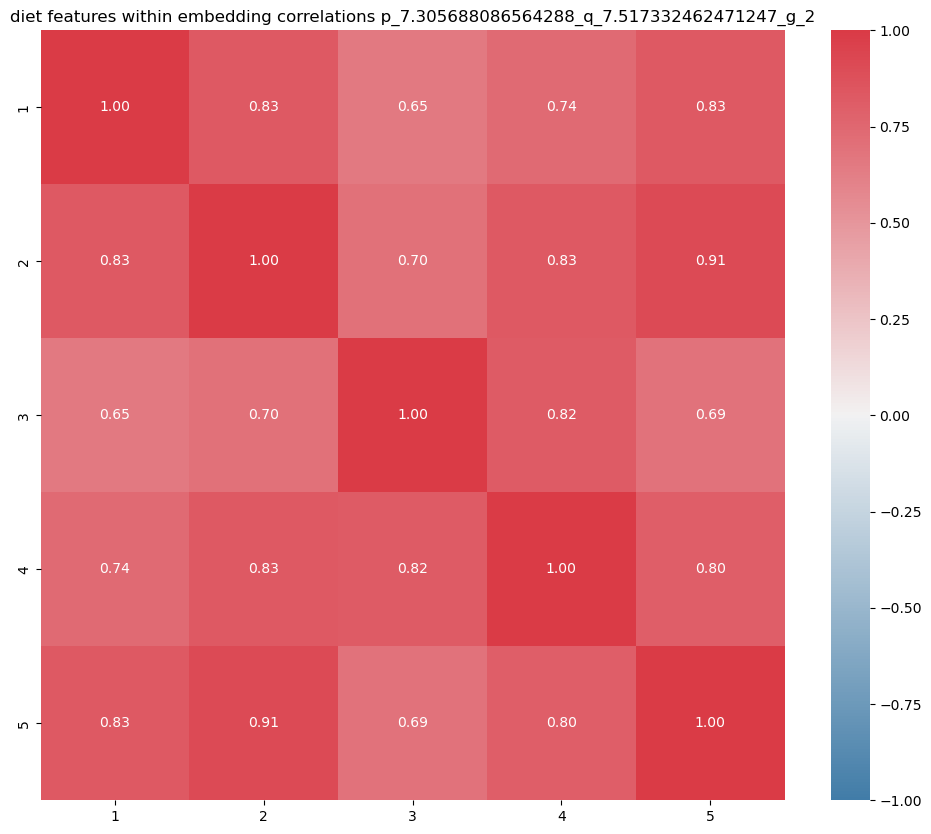

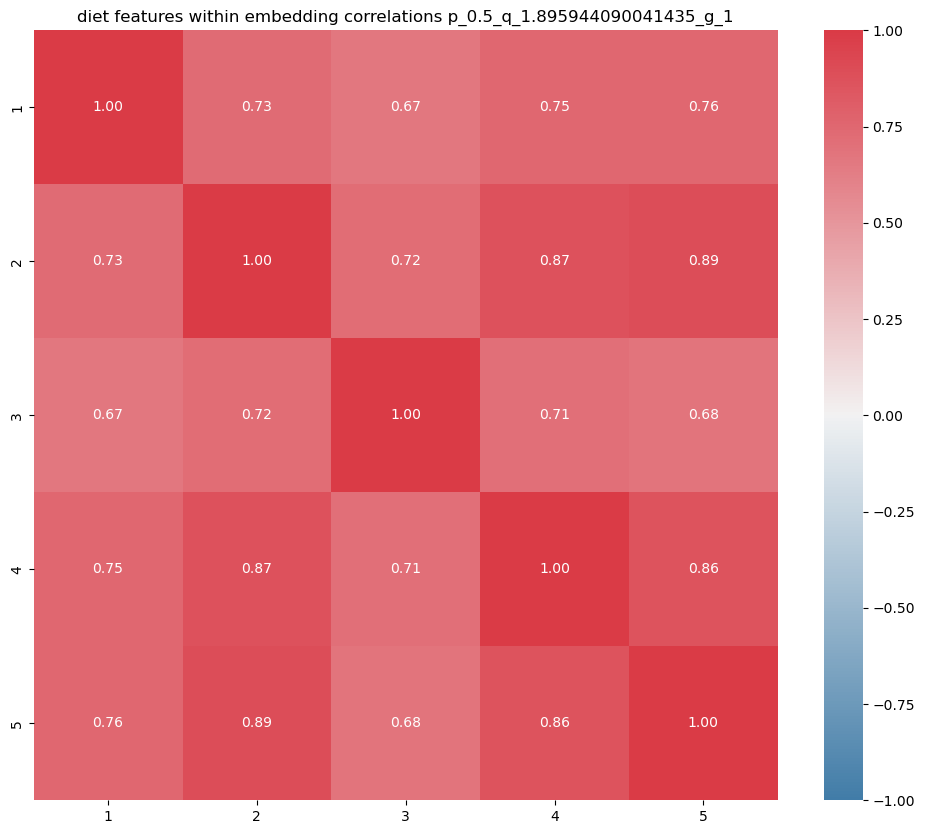

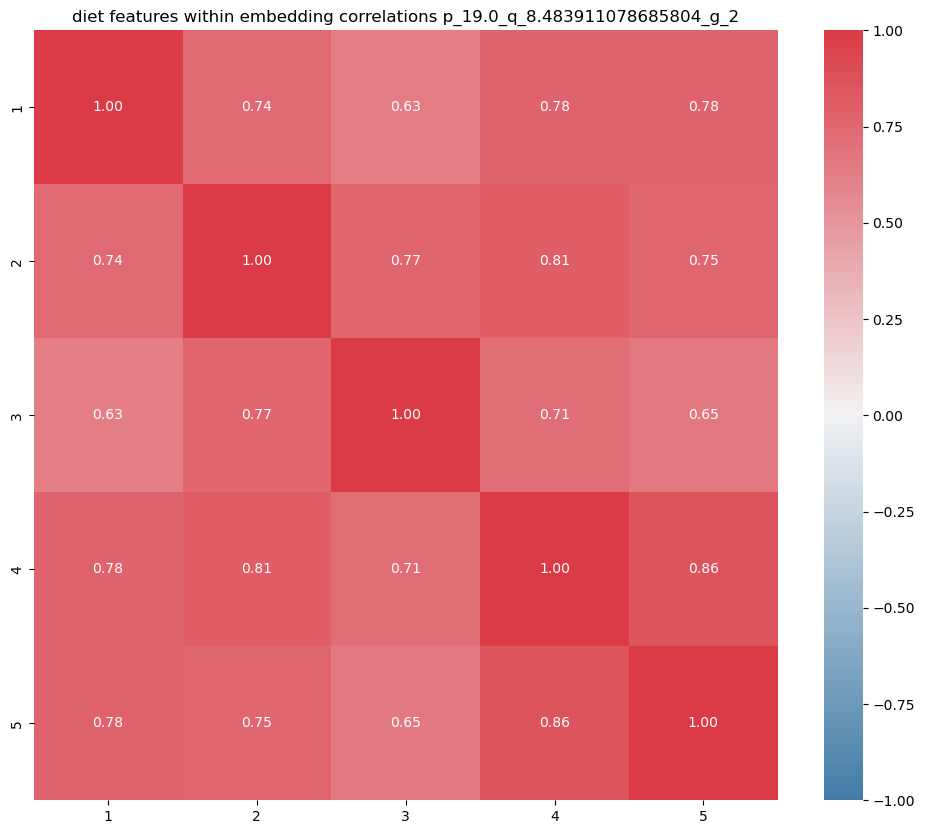

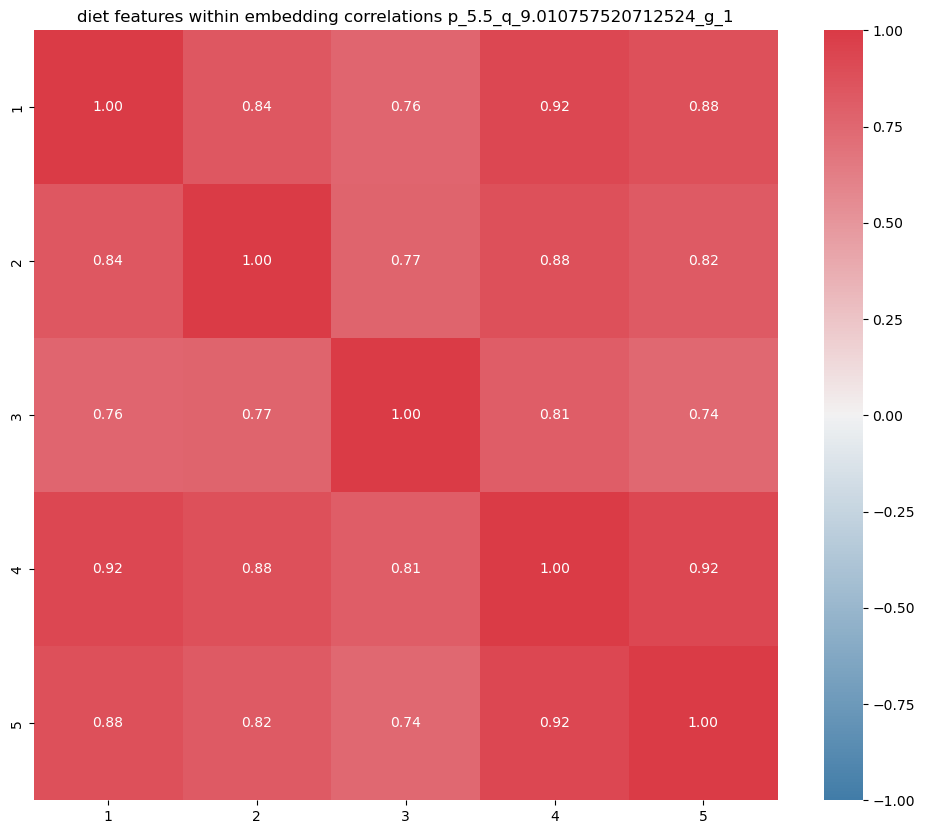

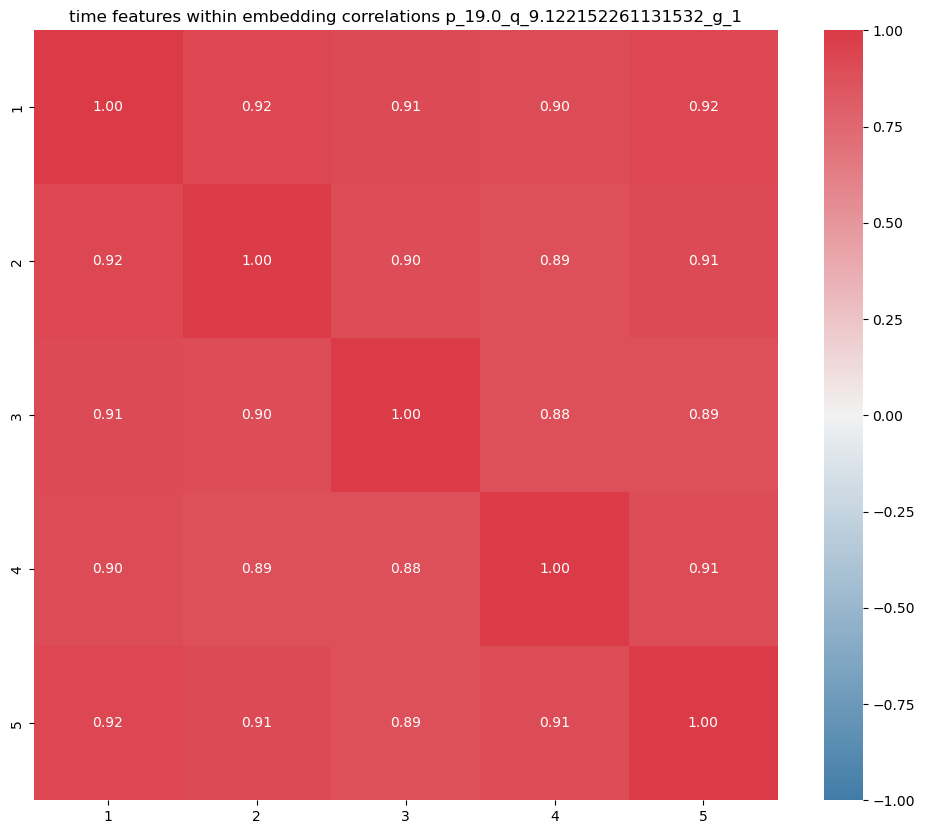

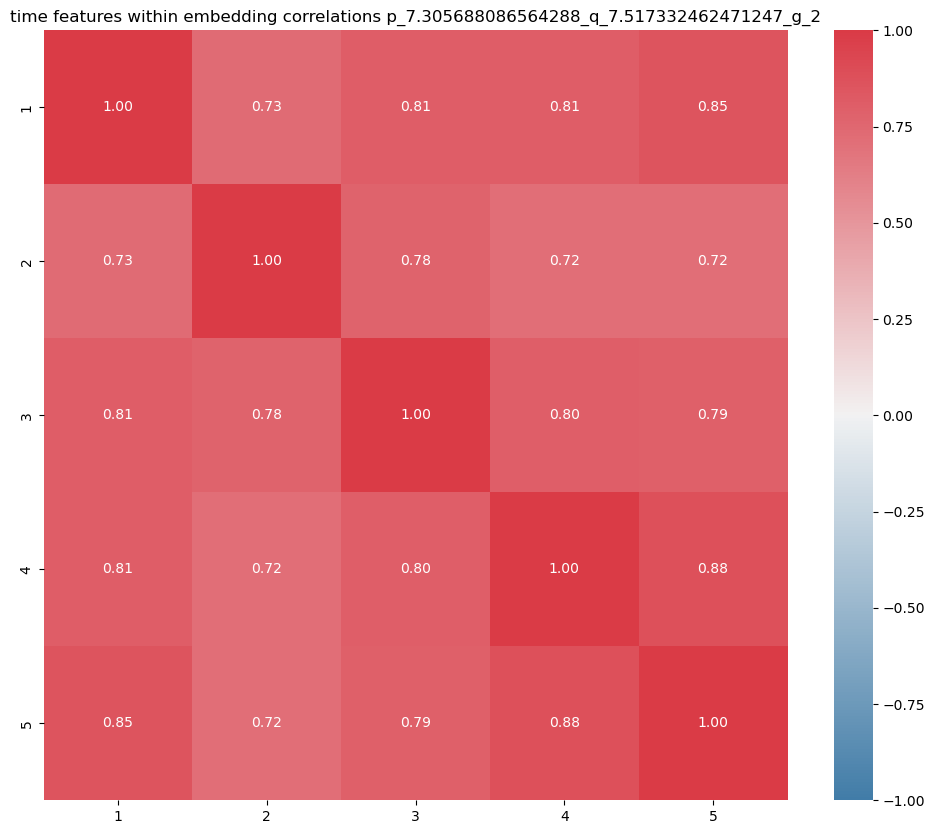

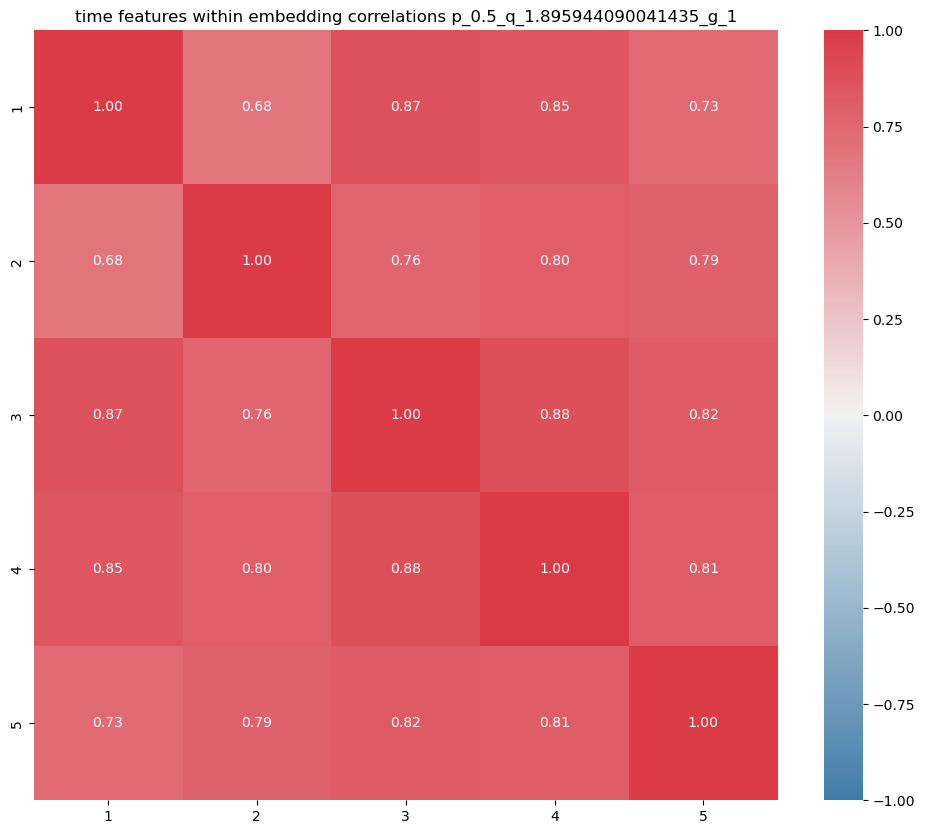

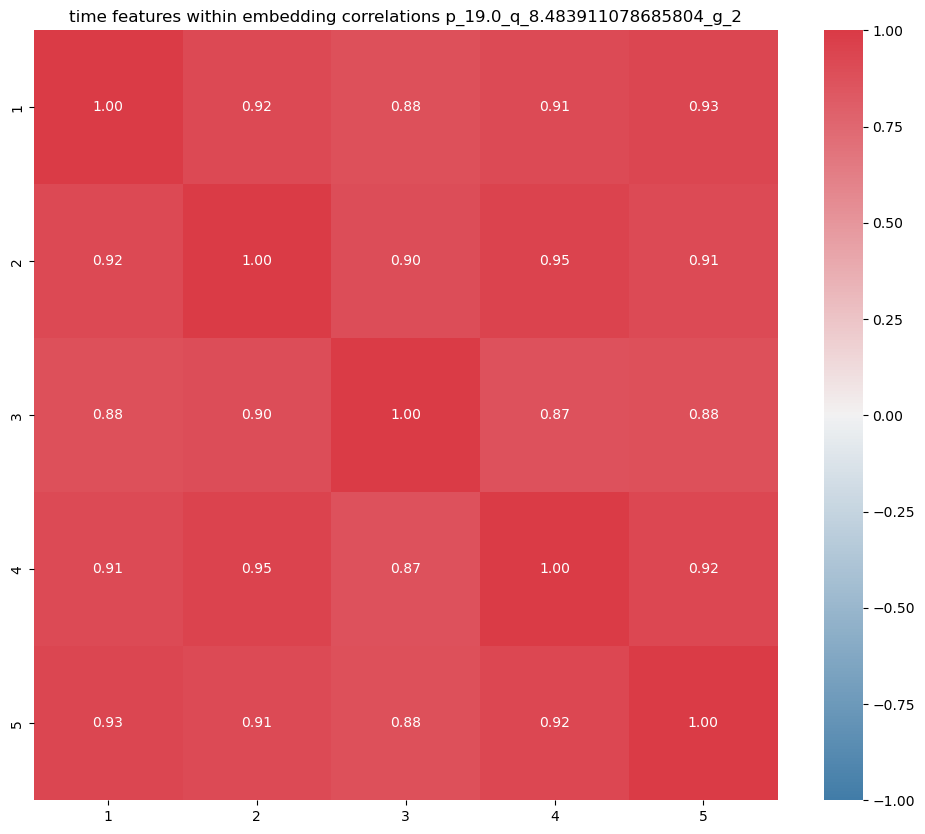

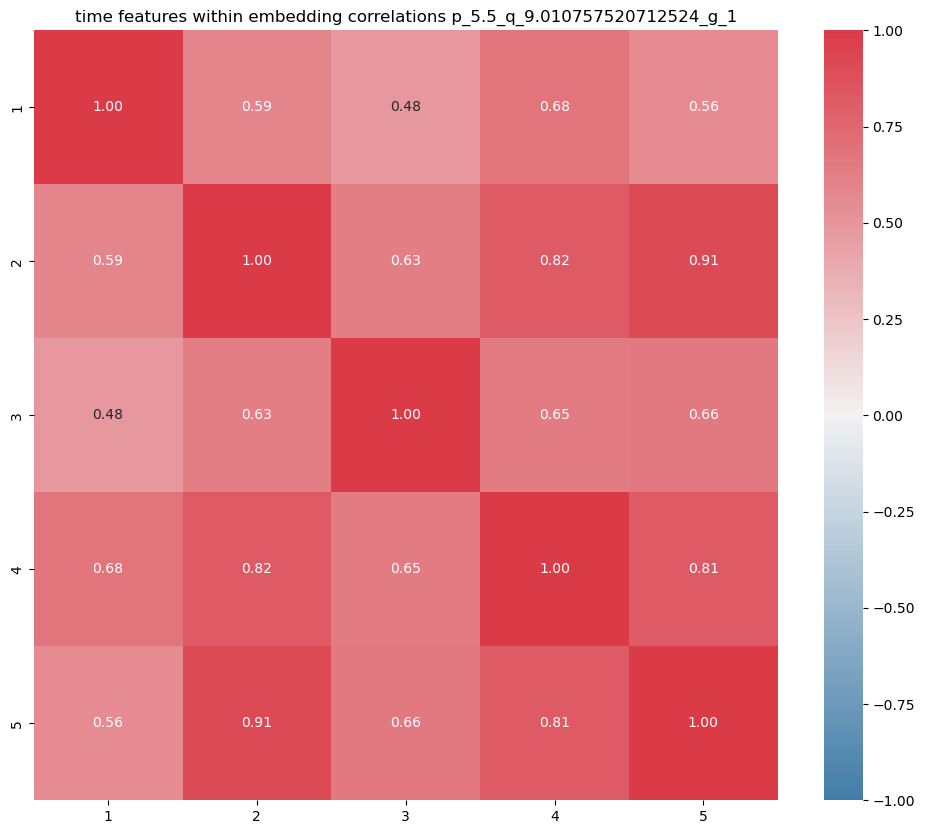

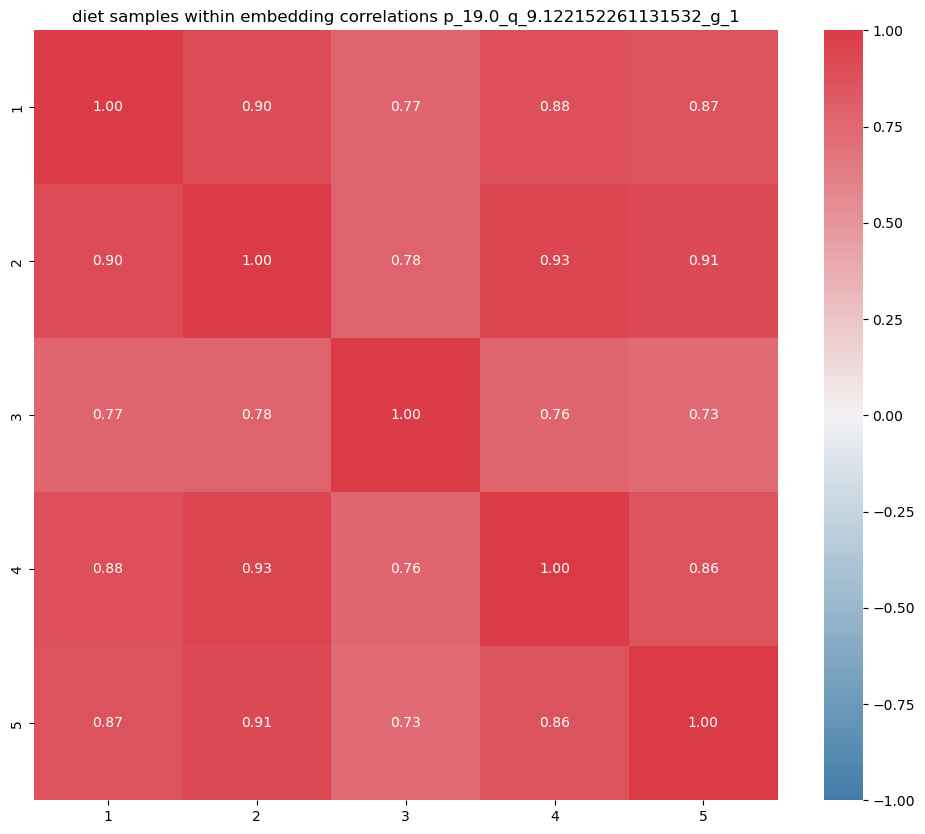

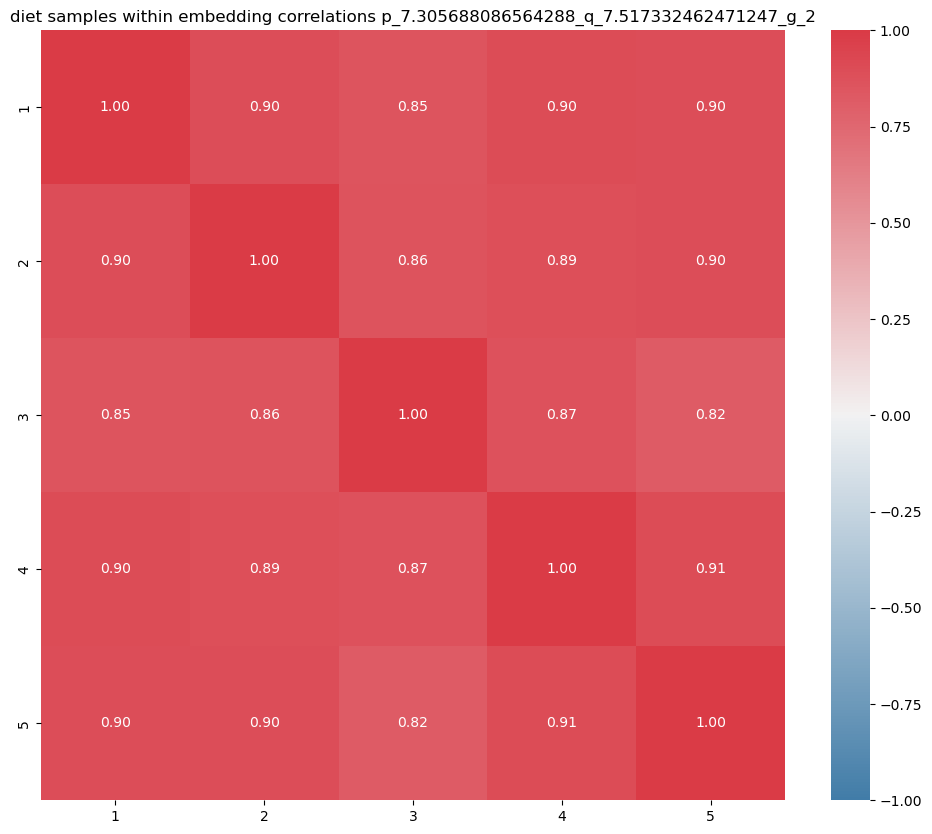

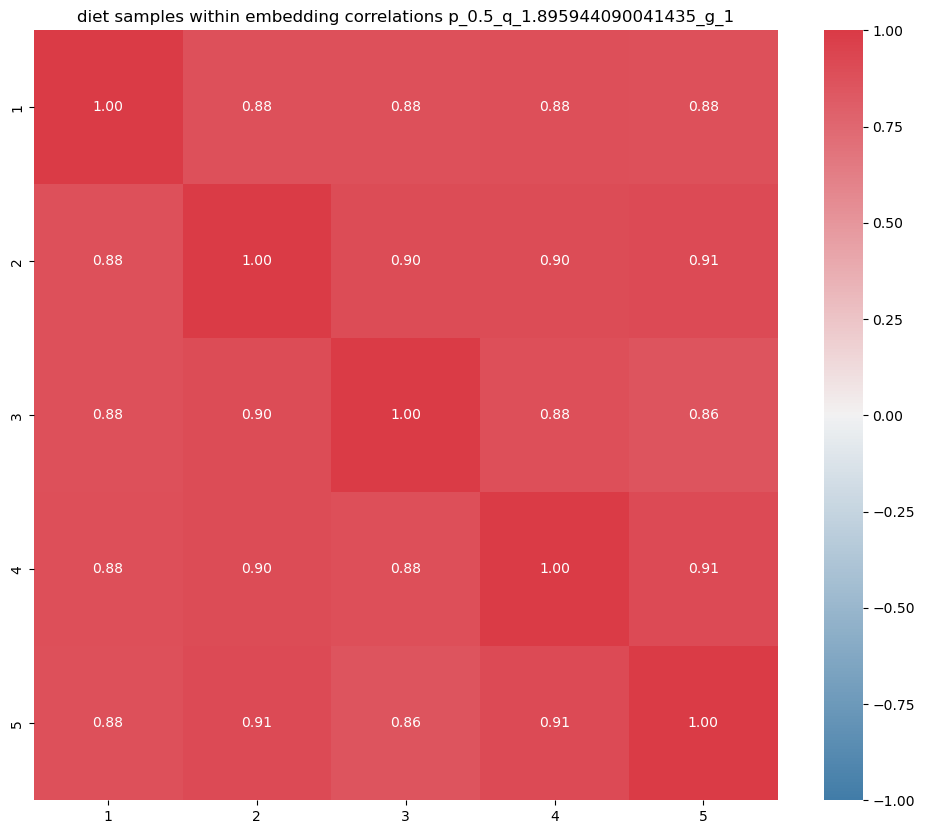

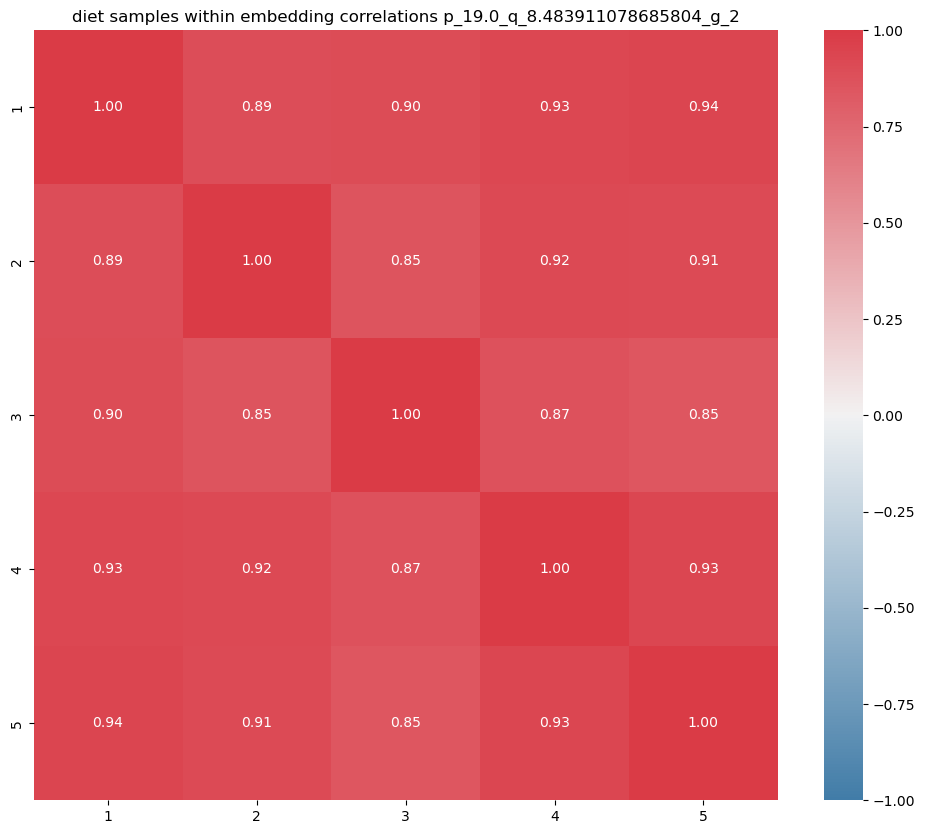

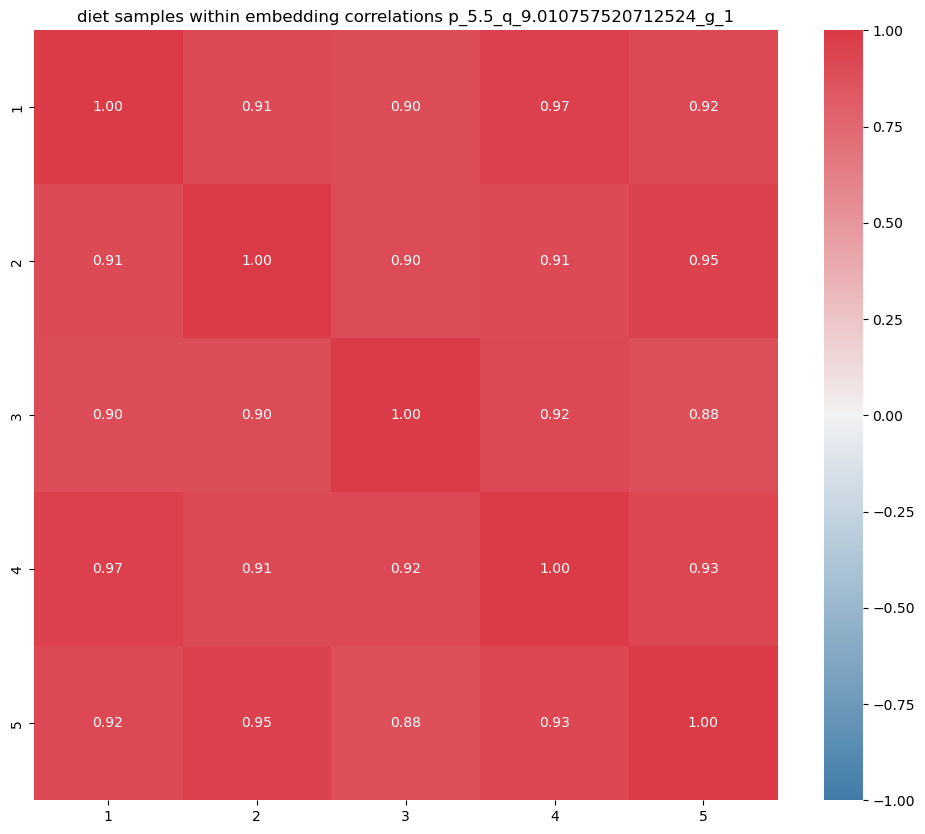

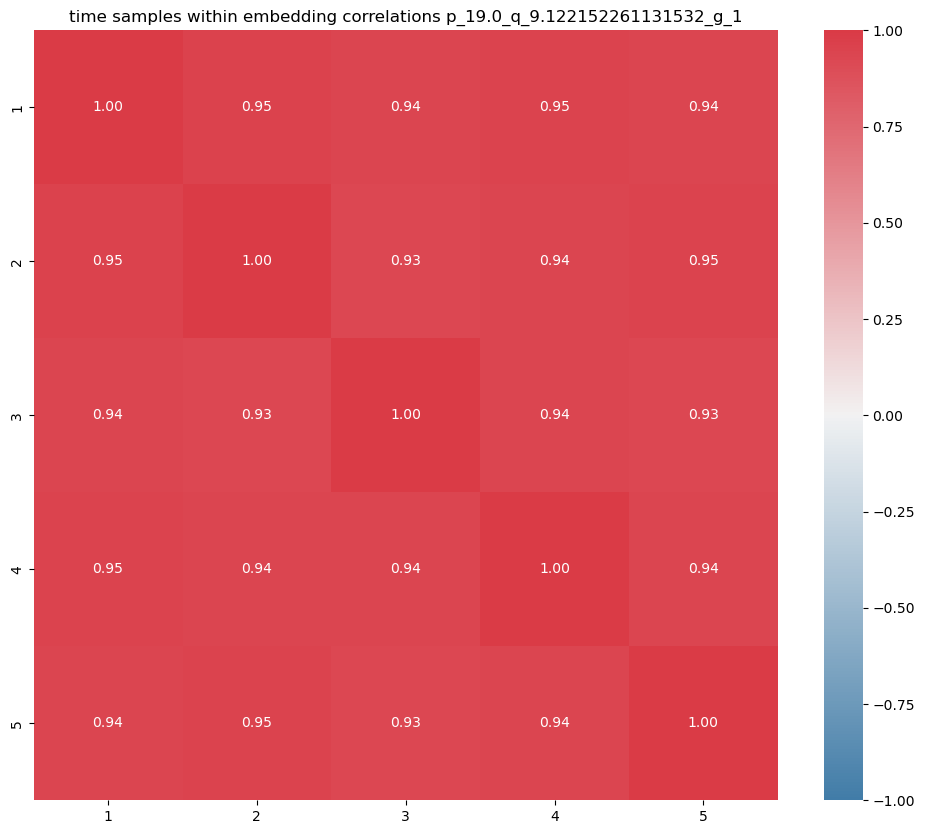

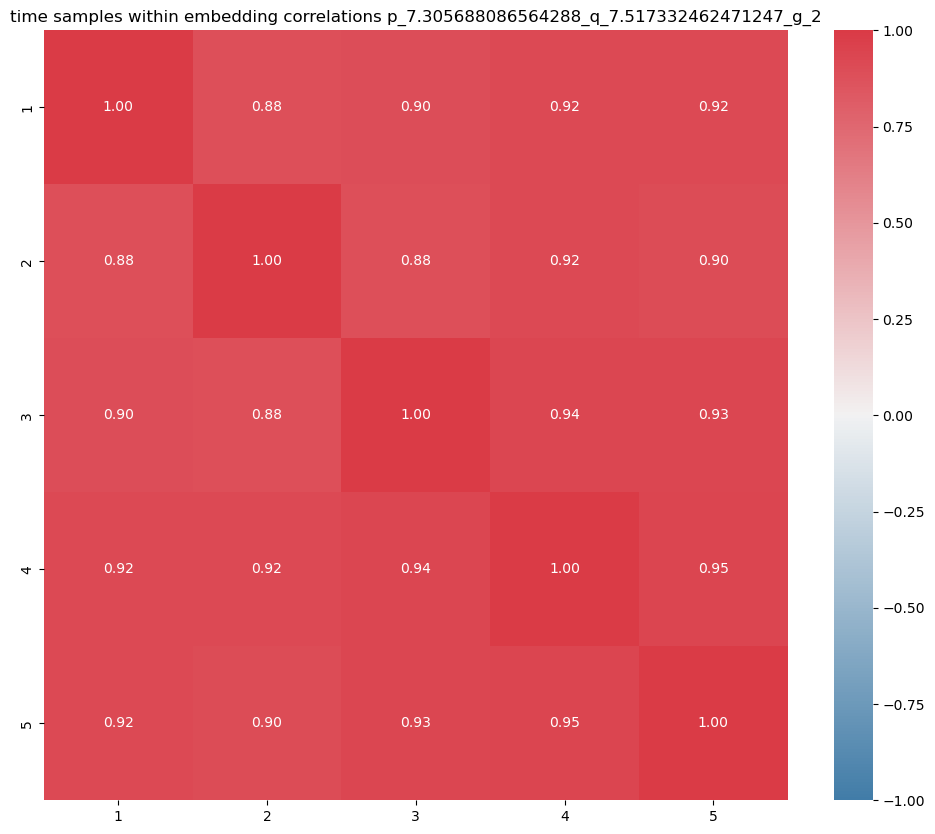

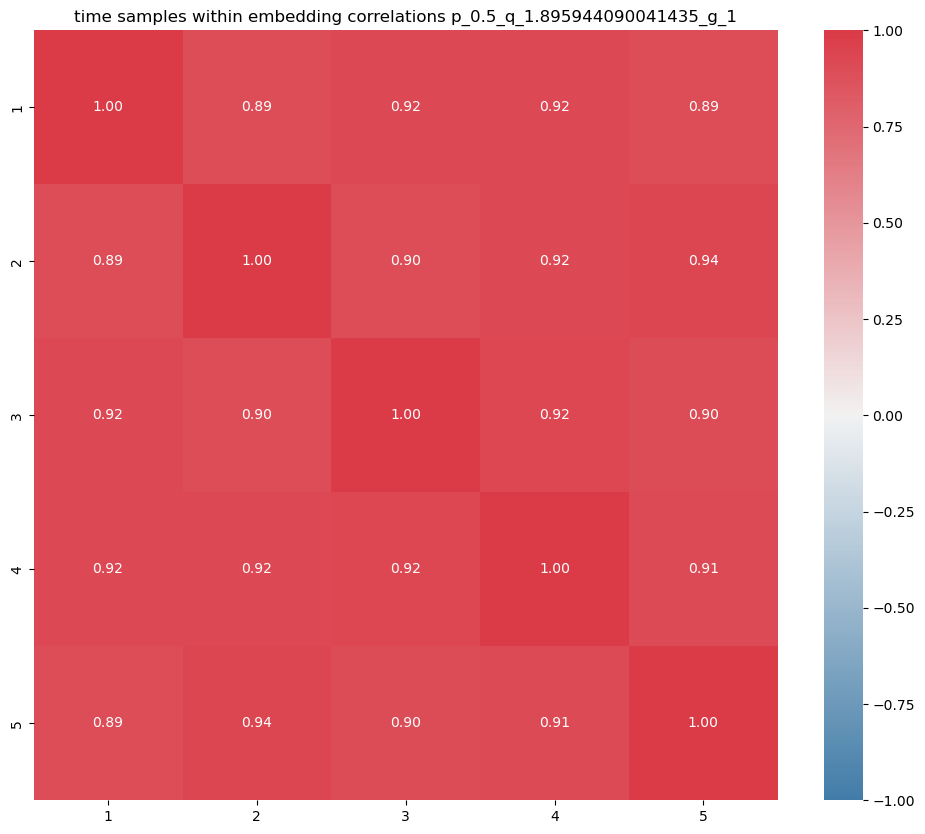

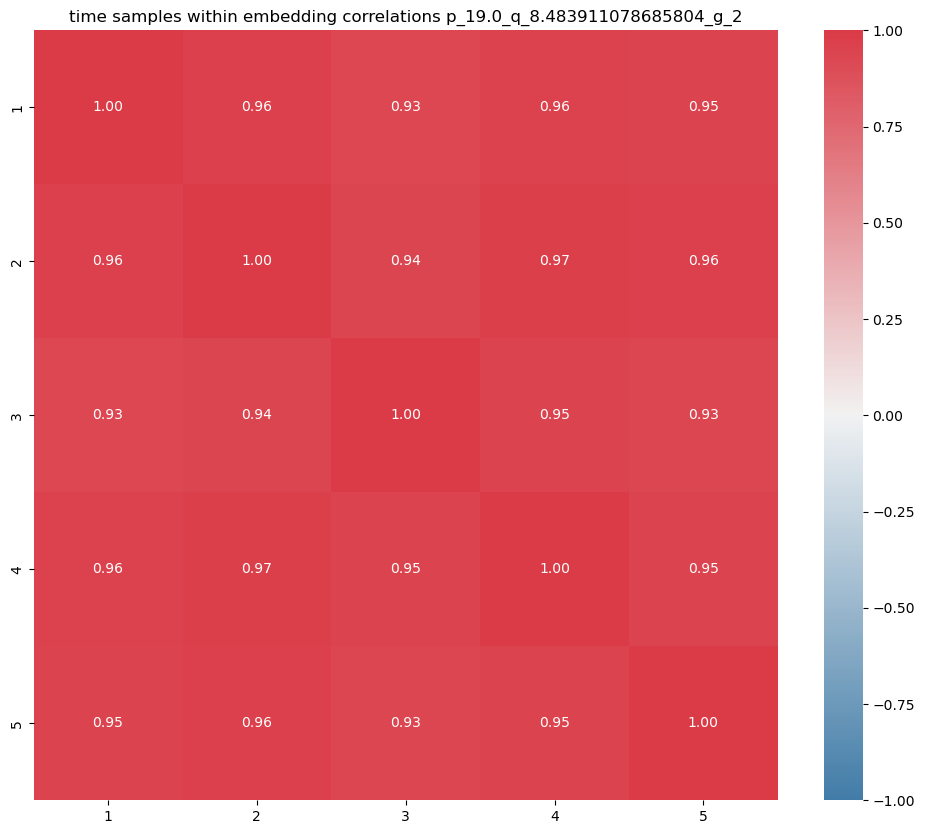

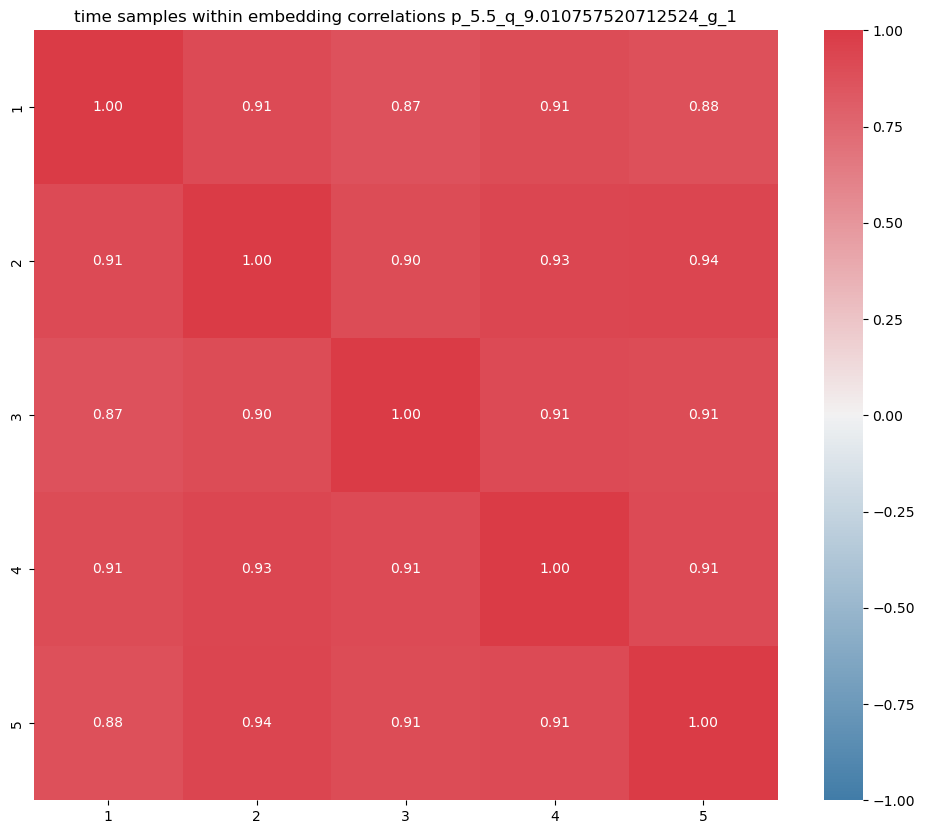

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def get_p_val(df, col1, col2):
    if col1 == col2:
        return 0
    else:
        corr, p_value = spearmanr(df[col1], df[col2])
        return p_value


def make_heatmap(correlation_matrix, classifier_type, data_type, correlation_type):
    plt.figure(figsize=(12, 10))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(correlation_matrix, cmap=cmap, center=0, vmin=-1, vmax=1, fmt=".2f", xticklabels=True, yticklabels=True, annot=True)
    plt.title(f'{classifier_type} {data_type} {correlation_type}')
    correlation_type = correlation_type.replace(' ', '_')
    plt.savefig(f'../results/correlations/heatmaps/{classifier_type}_{data_type}_{correlation_type}.png')

def get_val_correlation(predictions, classifier_type, data_type):
    val_cors = {}
    for params in predictions.keys():
        preds = pd.DataFrame(predictions[params])
        correlation_matrix = preds.corr(method='spearman')
        p_vals = pd.DataFrame([(col1, col2, get_p_val(preds, col1, col2)) 
                       for col1 in preds.columns for col2 in preds.columns], 
                      columns=['model_1', 'model_2', 'p_value'])
        p_vals = p_vals.pivot(index='model_1', columns='model_2', values='p_value')
        p_vals.to_csv(f'../results/correlations/{classifier_type}_{data_type}_{params}_p_vals.tsv', sep='\t')
        #correlation_matrix.to_csv(f'../results/correlations/{classifier_type}_{data_type}_{params}.tsv', sep='\t')
        make_heatmap(correlation_matrix, classifier_type, data_type, f'within embedding correlations {params}')
        corrs = np.triu(correlation_matrix, k=1)
        corrs = corrs[corrs > 0].flatten()
        val_cors[params] = np.mean(corrs)
    return val_cors


diet_features_val_cors = get_val_correlation(diet_features, 'diet', 'features')
time_features_val_cors = get_val_correlation(time_features, 'time', 'features')
diet_samples_val_cors = get_val_correlation(diet_samples, 'diet', 'samples')
time_samples_val_cors = get_val_correlation(time_samples, 'time', 'samples')
diet_features_val_cors, time_features_val_cors, diet_samples_val_cors, time_samples_val_cors
    

{'p_19.0_q_9.122152261131532_g_1+p_7.305688086564288_q_7.517332462471247_g_2': 0.08085083426899714, 'p_19.0_q_9.122152261131532_g_1+p_0.5_q_1.895944090041435_g_1': 0.08023210987477375, 'p_19.0_q_9.122152261131532_g_1+p_19.0_q_8.483911078685804_g_2': 0.17438332990851022, 'p_19.0_q_9.122152261131532_g_1+p_5.5_q_9.010757520712524_g_1': 0.17989404682734195, 'p_7.305688086564288_q_7.517332462471247_g_2+p_0.5_q_1.895944090041435_g_1': 0.09320076991792726, 'p_7.305688086564288_q_7.517332462471247_g_2+p_19.0_q_8.483911078685804_g_2': 0.05216826281804289, 'p_7.305688086564288_q_7.517332462471247_g_2+p_5.5_q_9.010757520712524_g_1': 0.1626675247930879, 'p_0.5_q_1.895944090041435_g_1+p_19.0_q_8.483911078685804_g_2': 0.10185306261403874, 'p_0.5_q_1.895944090041435_g_1+p_5.5_q_9.010757520712524_g_1': 0.1027045403798432, 'p_19.0_q_8.483911078685804_g_2+p_5.5_q_9.010757520712524_g_1': 0.11537140700953533}
{'p_19.0_q_9.122152261131532_g_1+p_7.305688086564288_q_7.517332462471247_g_2': 0.2590255419346807

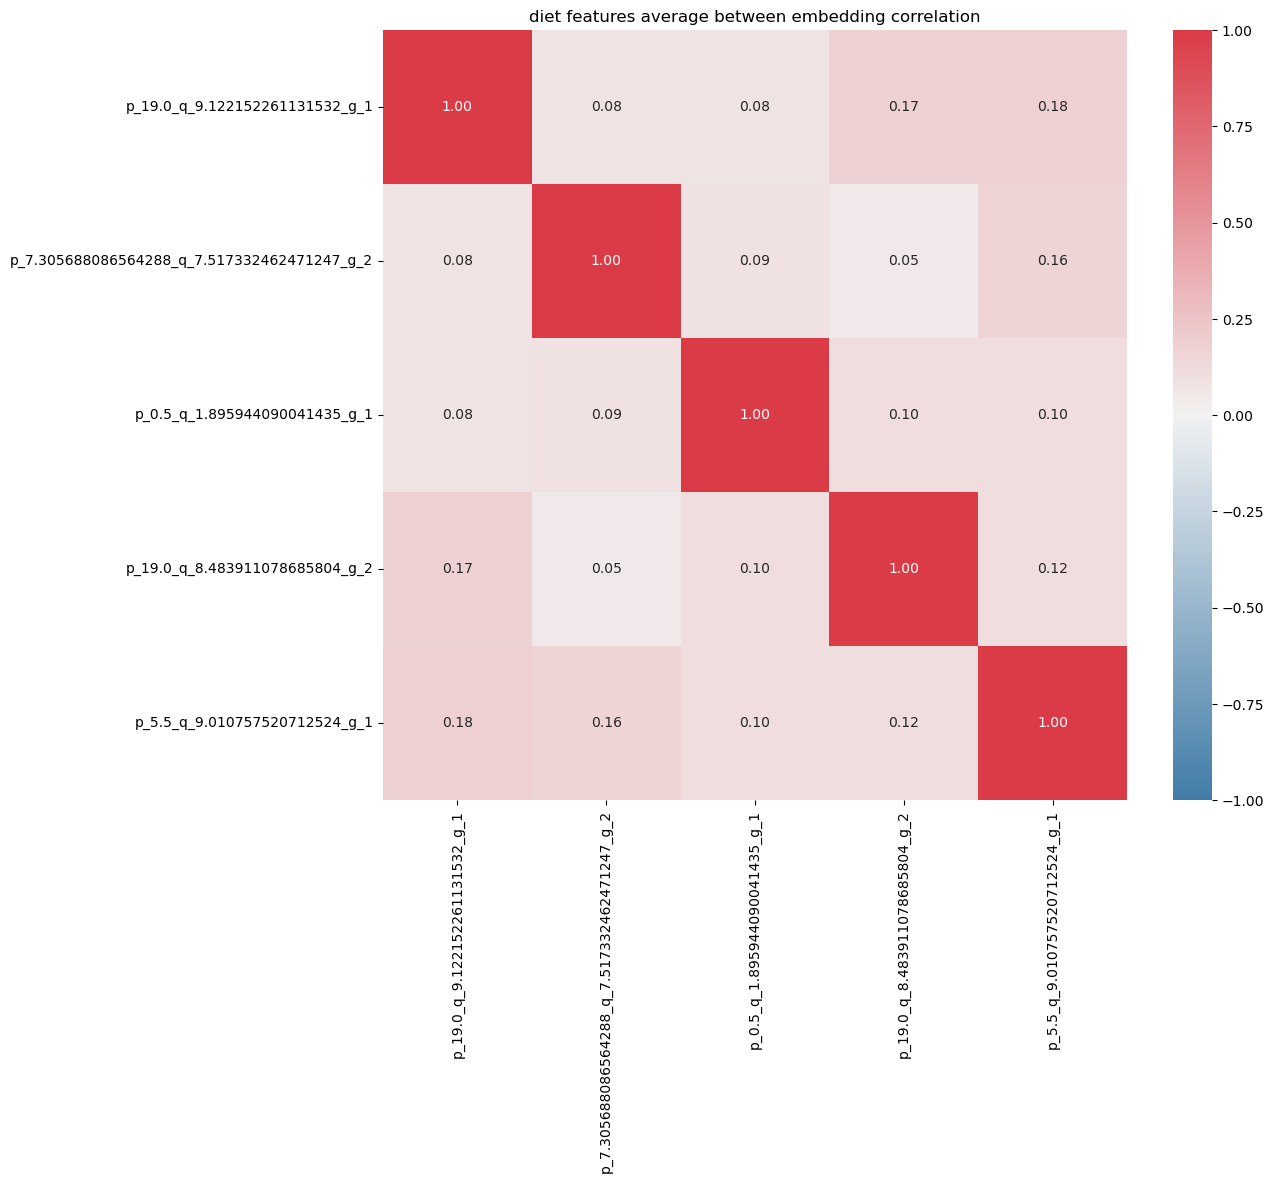

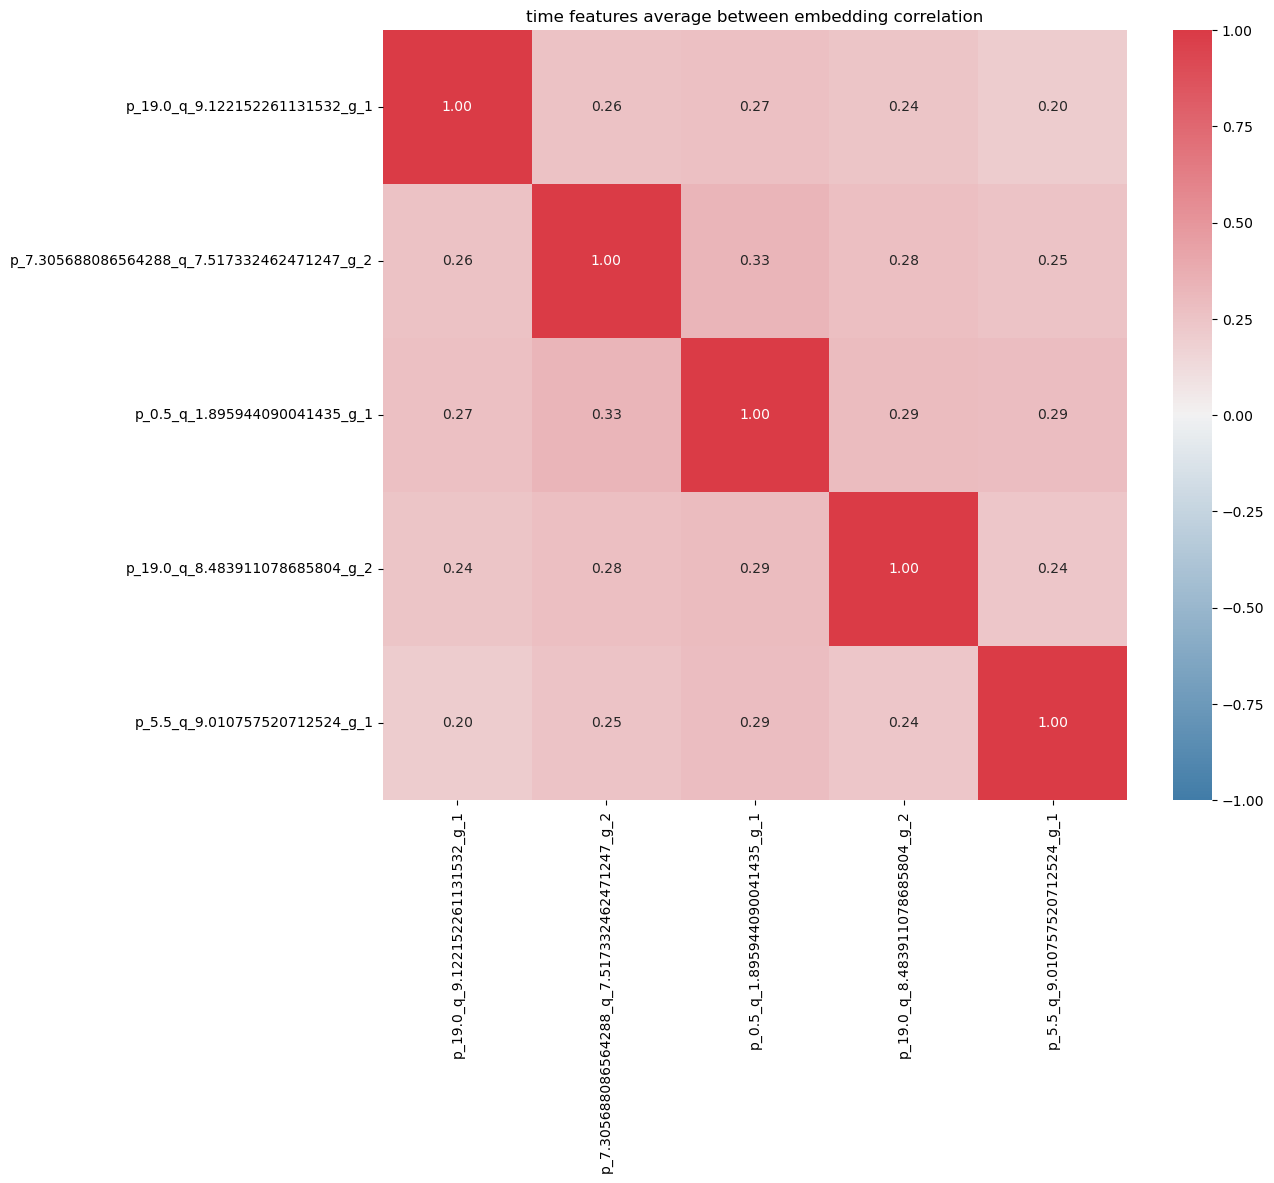

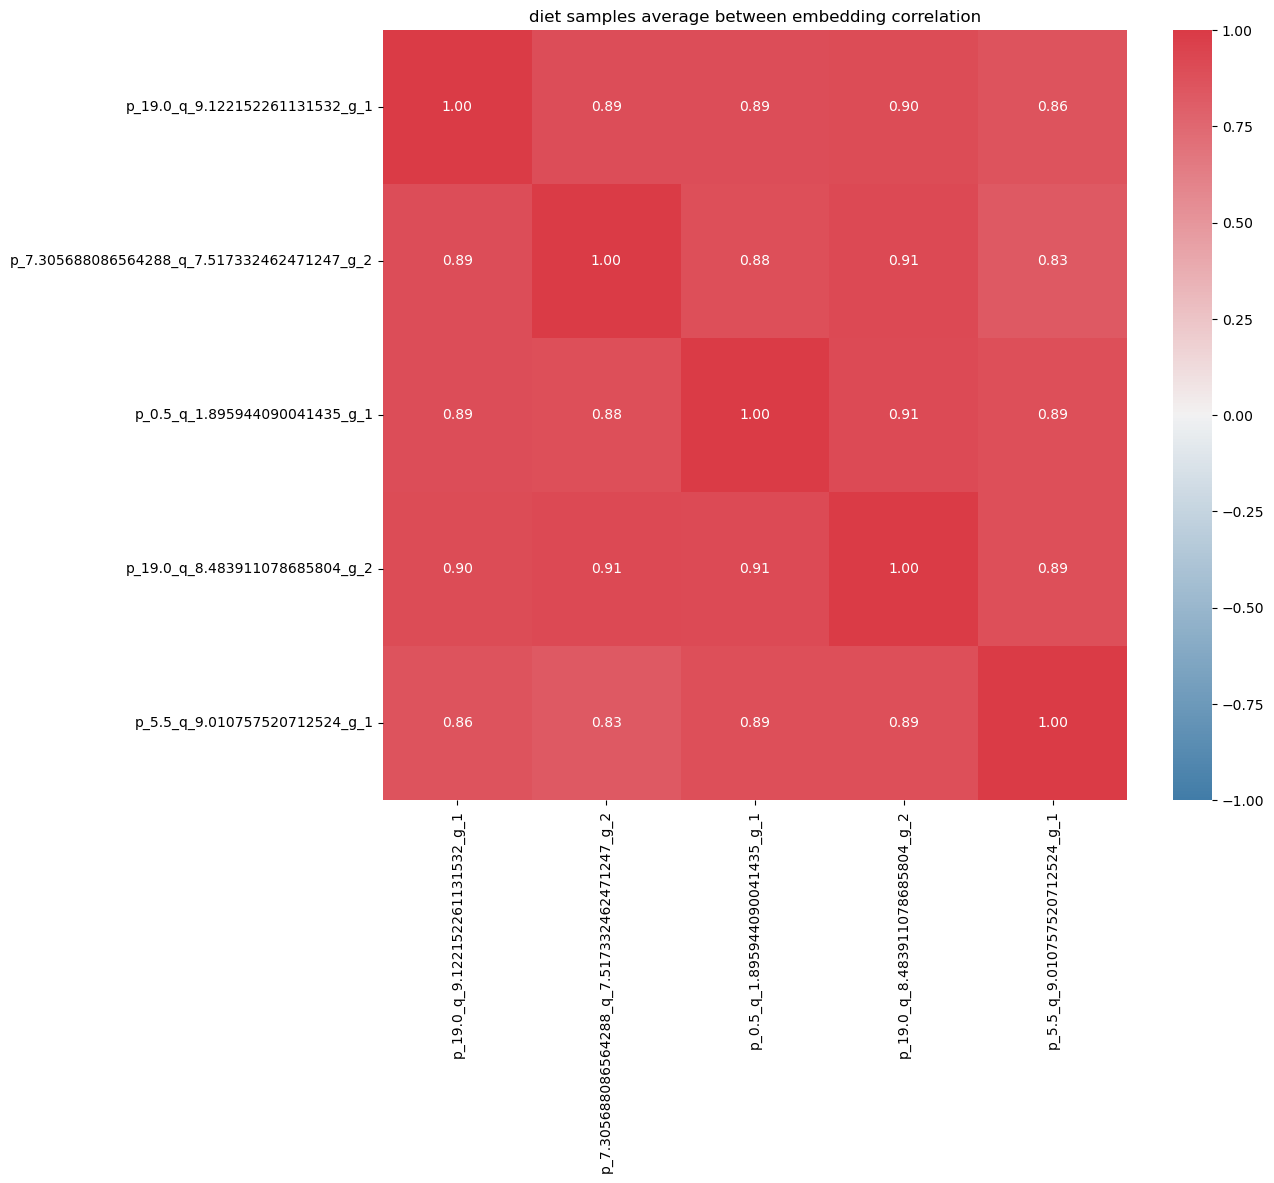

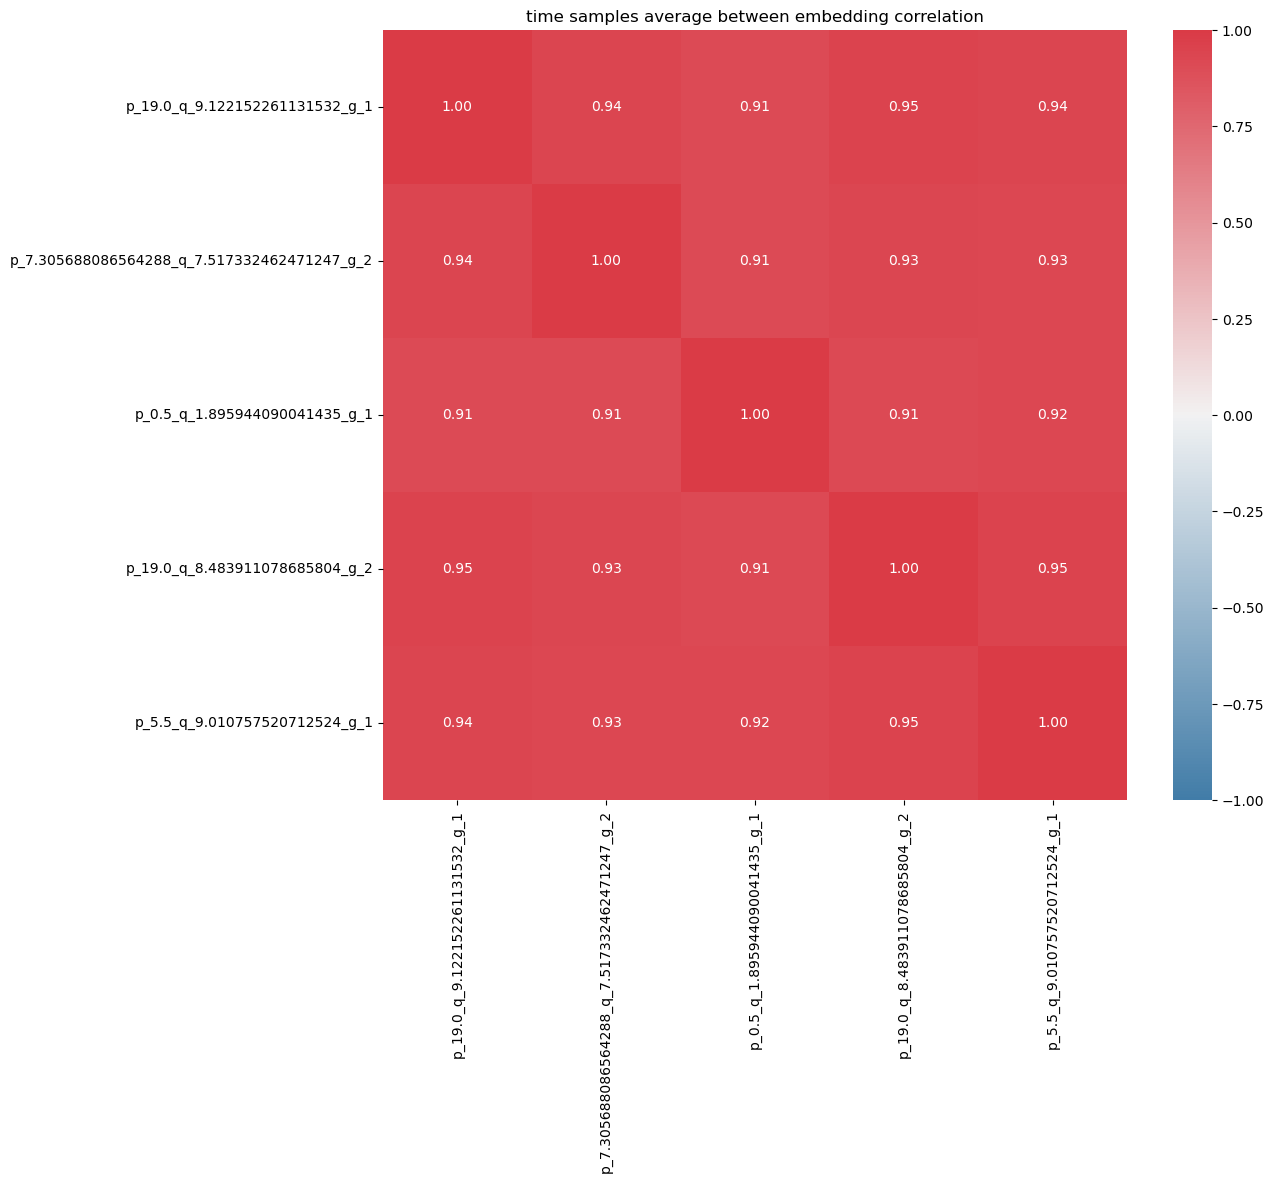

In [5]:
def get_avg_predictions(predictions):
    avg_preds = {}
    for params in predictions.keys():
        preds = pd.DataFrame(predictions[params])
        avg_preds[params] = preds.mean(axis=1).to_list()
    return avg_preds

def get_avg_param_correlation(predictions, classifier_type, data_type):
    avg_corrs = {}
    avg_preds = pd.DataFrame(get_avg_predictions(predictions))
    correlation_matrix = avg_preds.corr(method='spearman')
    p_vals = pd.DataFrame([(col1, col2, get_p_val(avg_preds, col1, col2)) 
                       for col1 in avg_preds.columns for col2 in avg_preds.columns], 
                      columns=['emb_1', 'emb_2', 'p_value'])
    p_vals = p_vals.pivot(index='emb_1', columns='emb_2', values='p_value')
    p_vals.to_csv(f'../results/correlations/avg_{classifier_type}_{data_type}_p_vals.tsv', sep='\t')
    make_heatmap(correlation_matrix, classifier_type, data_type, 'average between embedding correlation')
    corrs = pd.DataFrame(np.triu(correlation_matrix, k=1), index=correlation_matrix.index, columns=correlation_matrix.columns)
    #correlation_matrix.to_csv(f'../results/correlations/avg_{classifier_type}_{data_type}.tsv', sep='\t')
    for row in corrs.index:
        for col in corrs.columns:
            if corrs.loc[row, col] > 0:
                avg_corrs[f'{row}+{col}'] = corrs.loc[row, col]
    print(avg_corrs)
    return avg_corrs

diet_features_avg_corr = get_avg_param_correlation(diet_features, 'diet', 'features')
time_features_avg_corr = get_avg_param_correlation(time_features, 'time', 'features')
diet_samples_avg_corr = get_avg_param_correlation(diet_samples, 'diet', 'samples')
time_samples_avg_corr = get_avg_param_correlation(time_samples, 'time', 'samples')

({1: 0.09859448777294658,
  2: 0.08872930183443233,
  3: 0.13233127095246172,
  4: 0.1215778715297438,
  5: 0.09202826534345024},
 {1: 0.20962595916949778,
  2: 0.2616427044560458,
  3: 0.1979334946442653,
  4: 0.23148055201455847,
  5: 0.2410067357874713},
 {1: 0.8925467429352002,
  2: 0.8724323401348928,
  3: 0.8622043882865192,
  4: 0.8575514385725264,
  5: 0.9022026807820371},
 {1: 0.9212890371605968,
  2: 0.9096385877119821,
  3: 0.917459920303957,
  4: 0.9080808080808082,
  5: 0.8826503567787972})

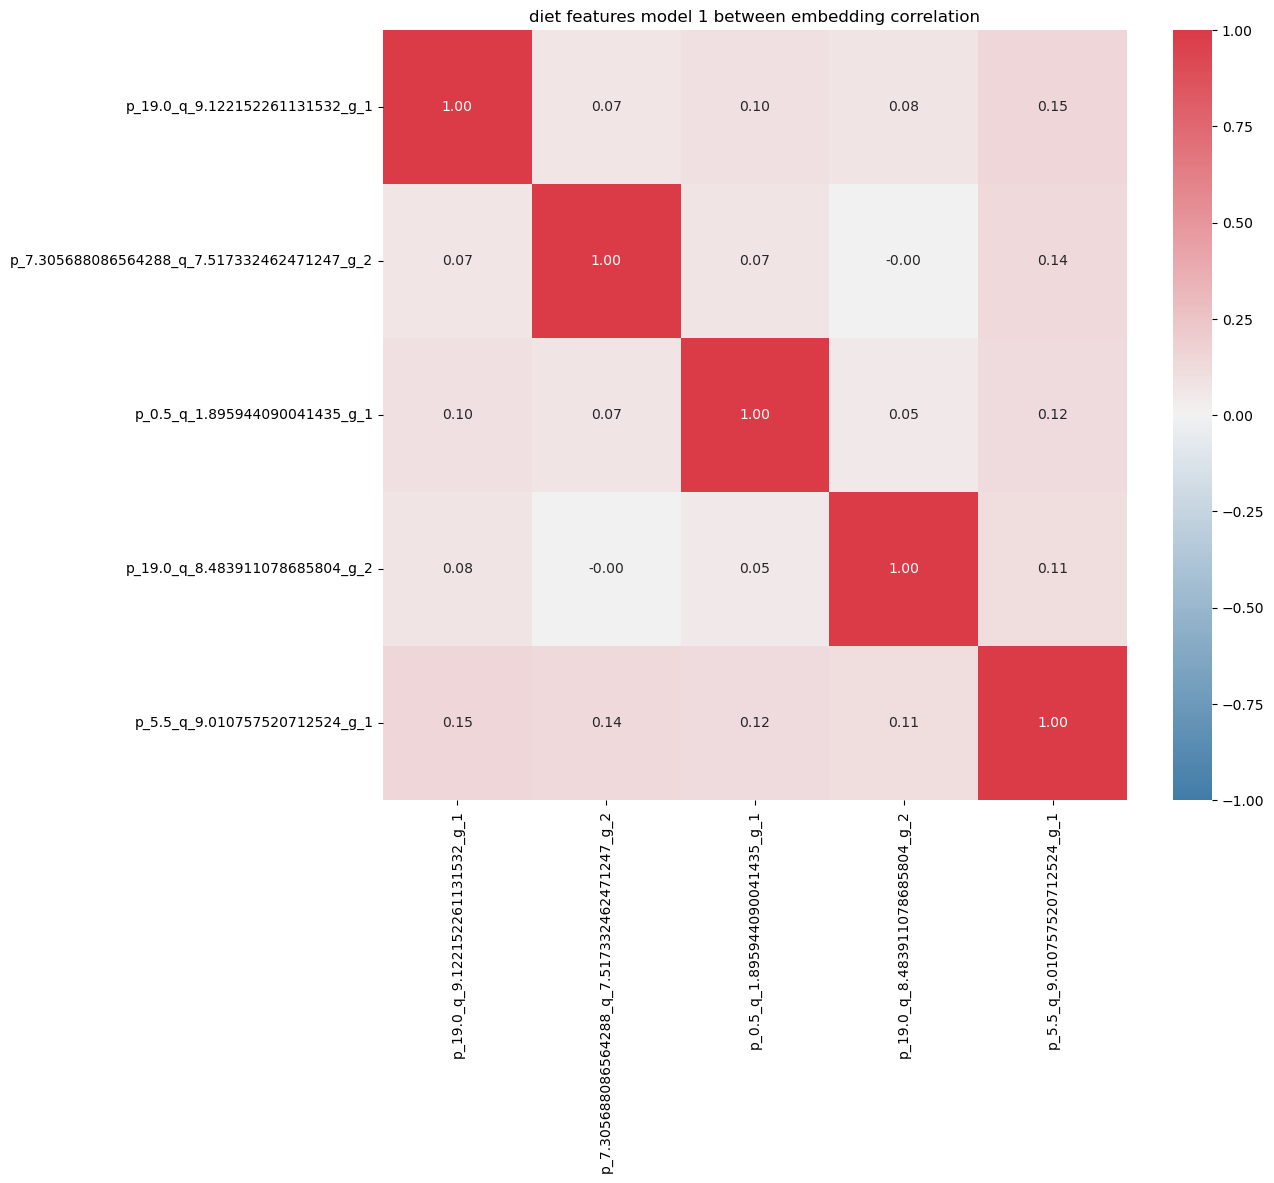

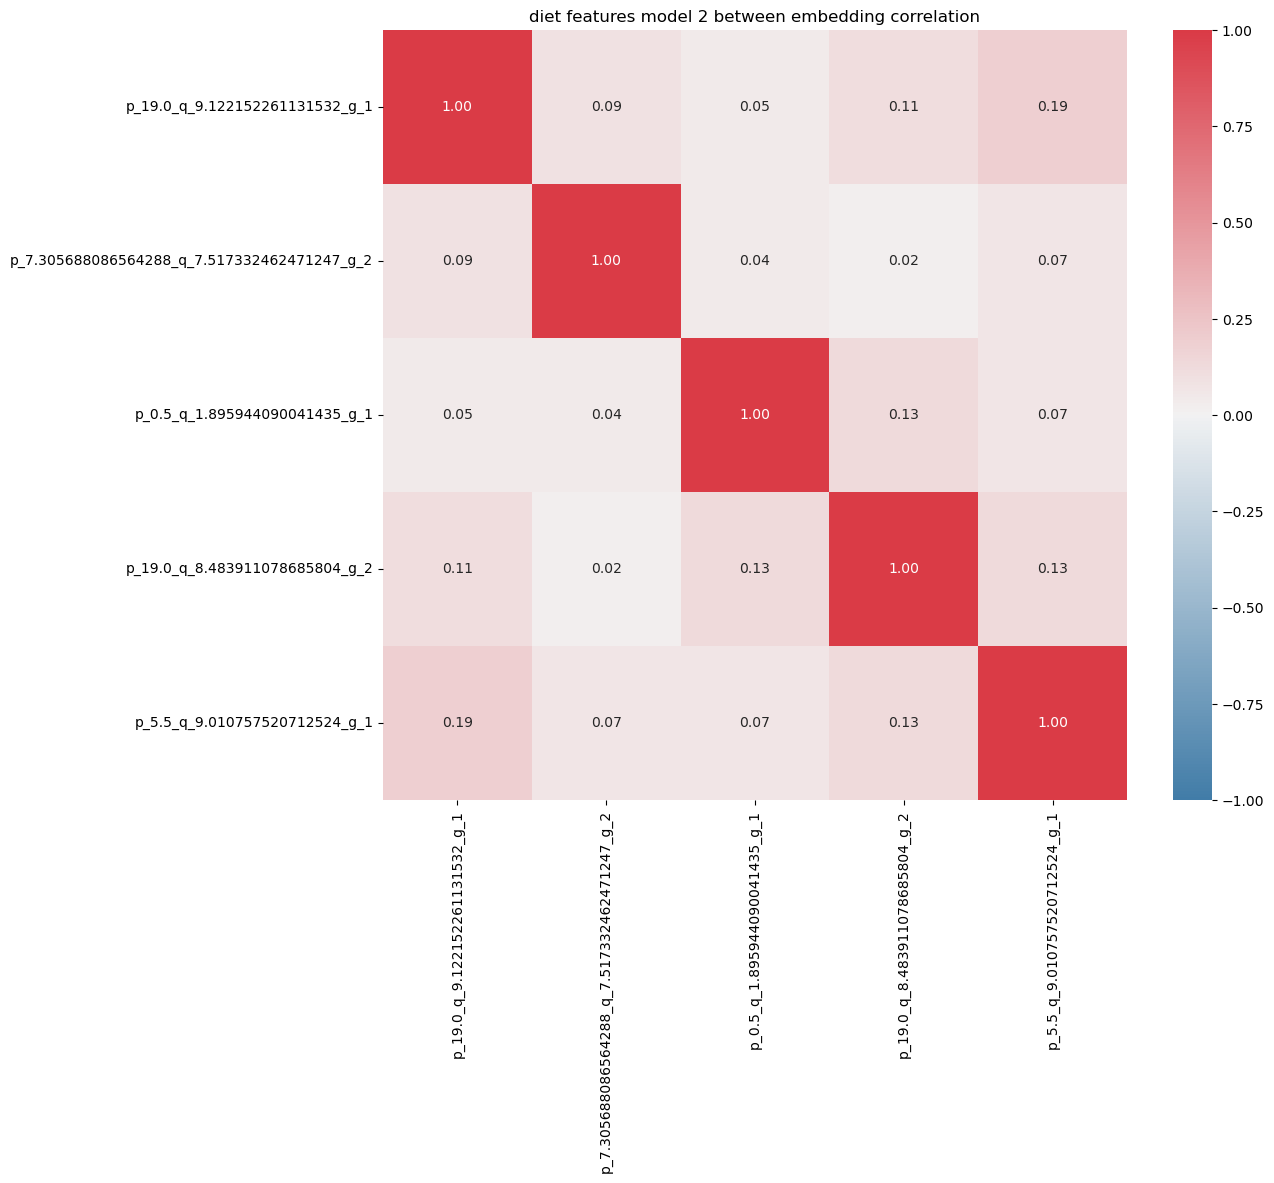

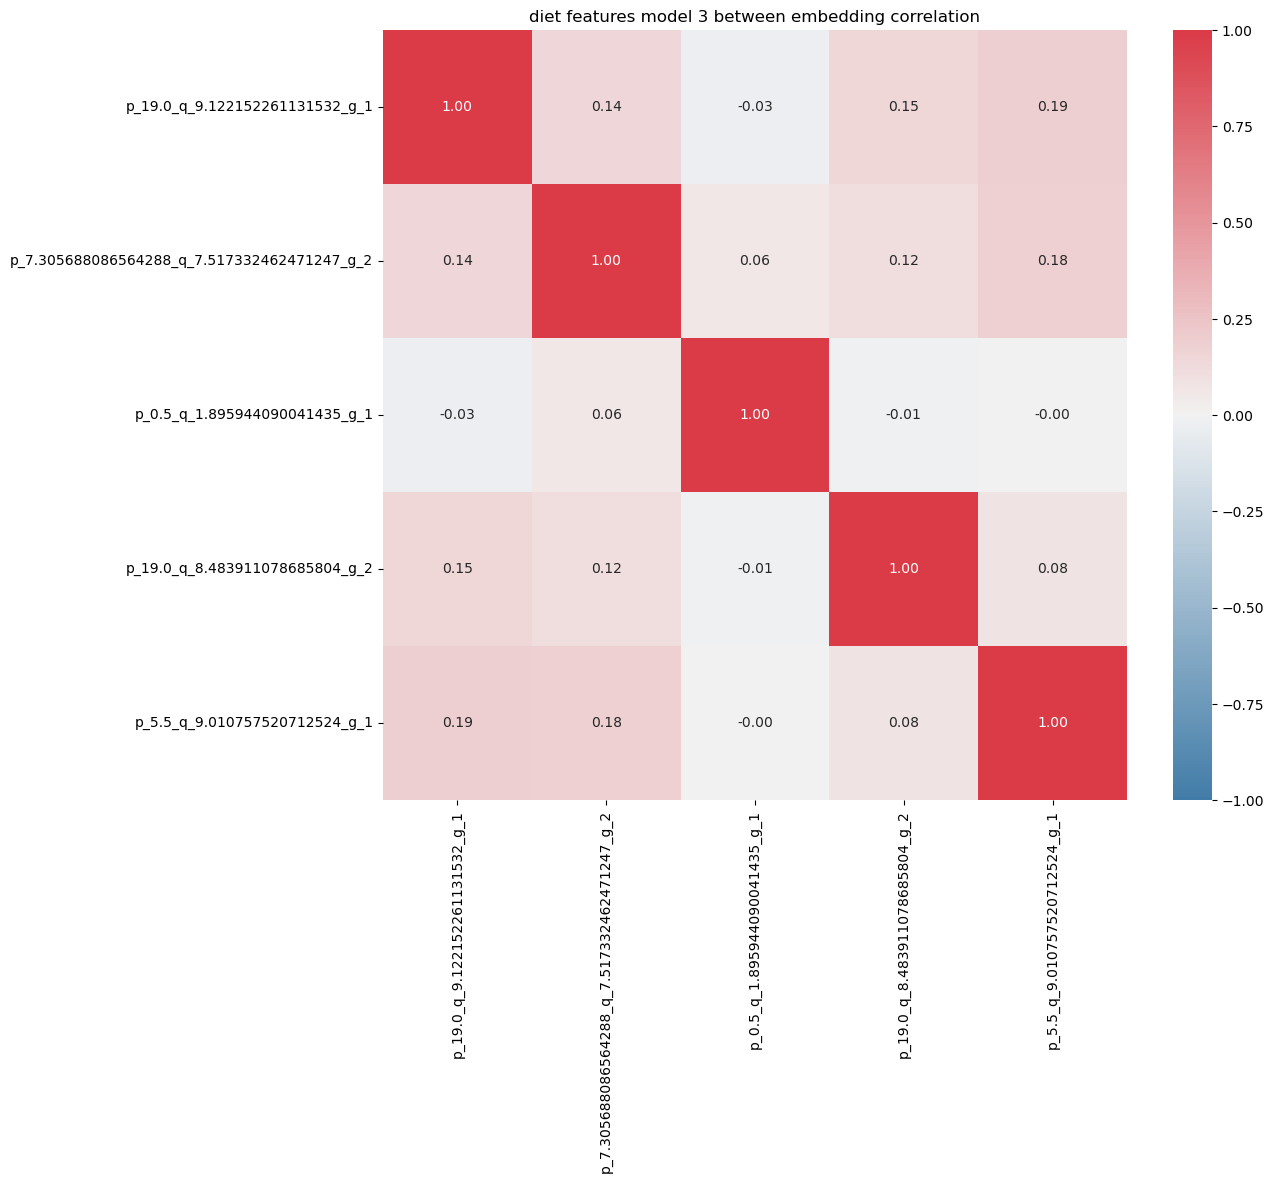

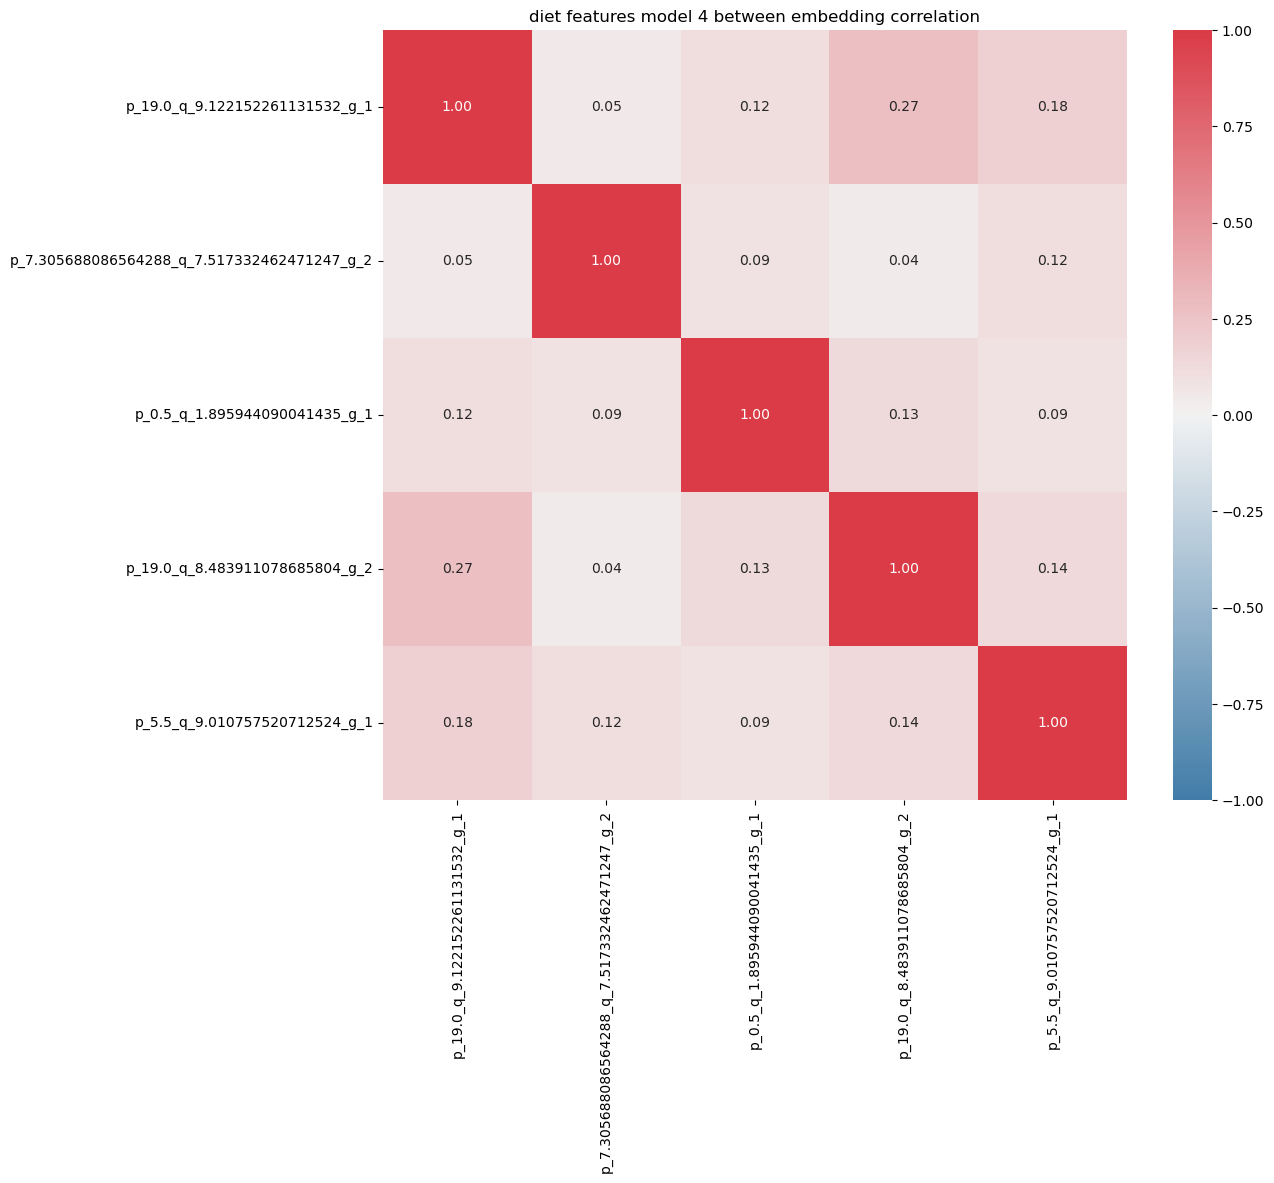

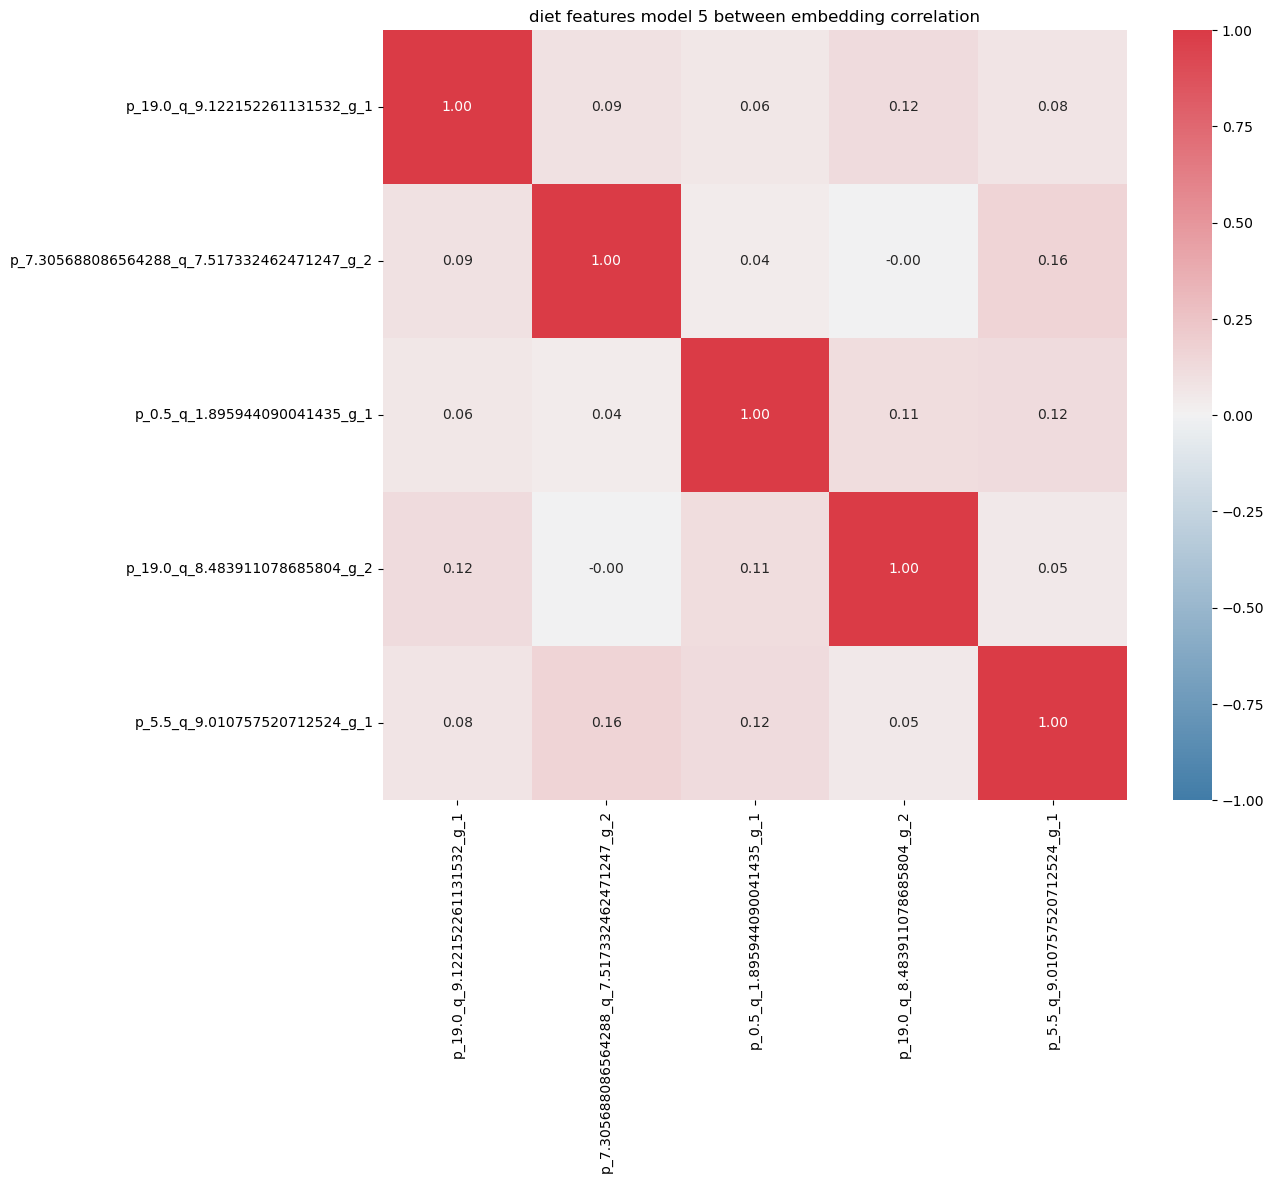

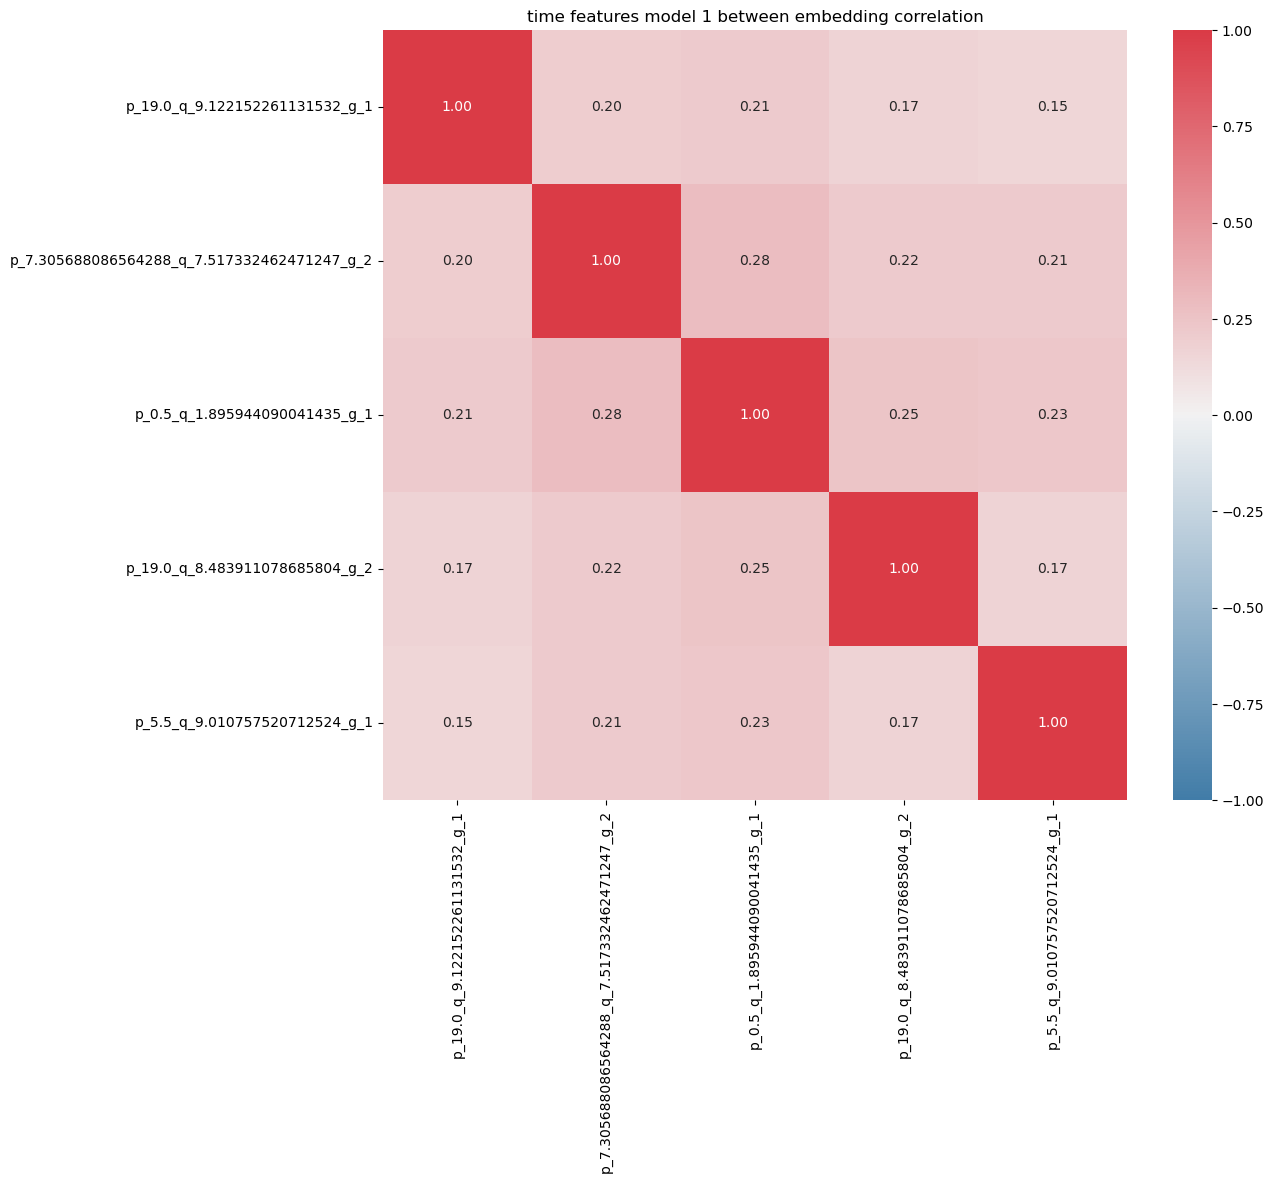

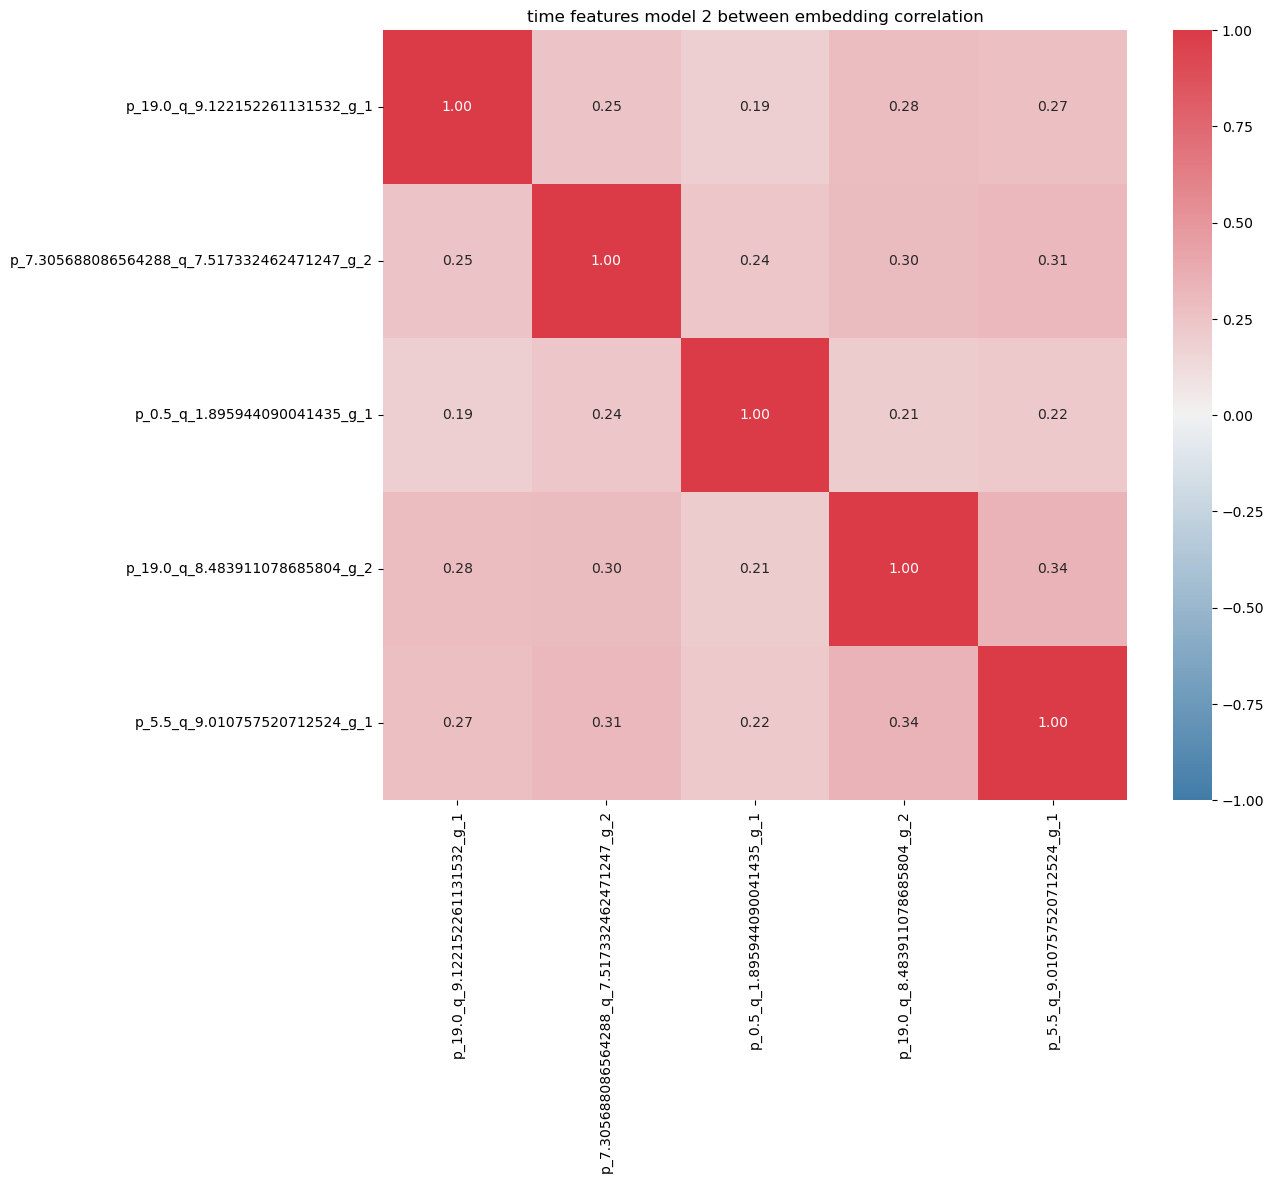

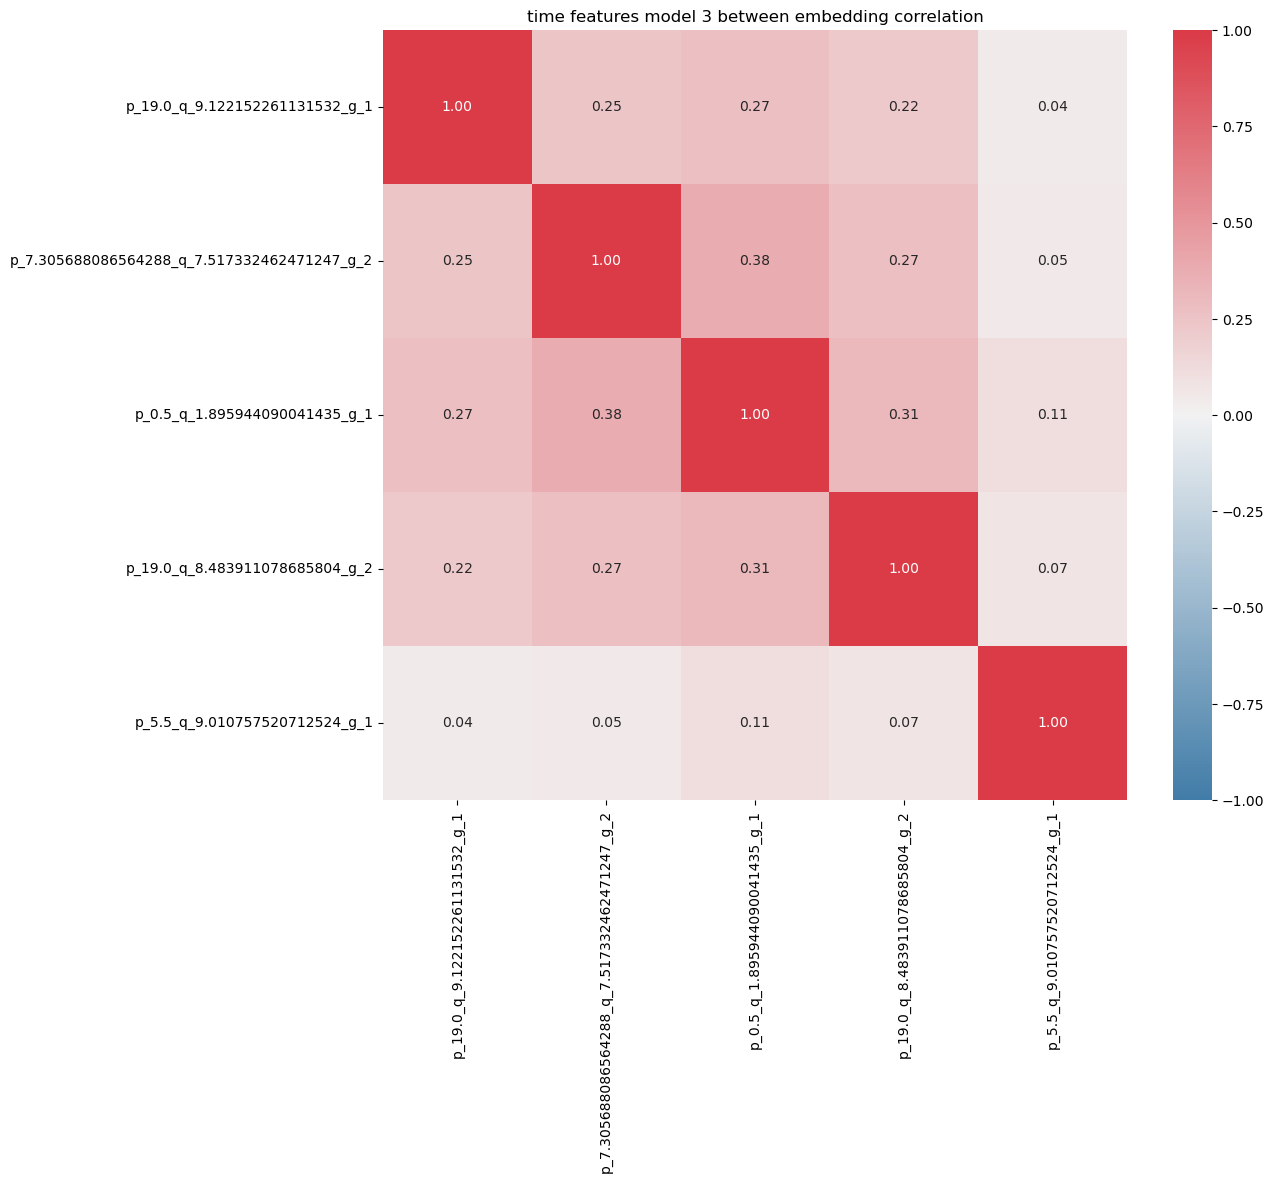

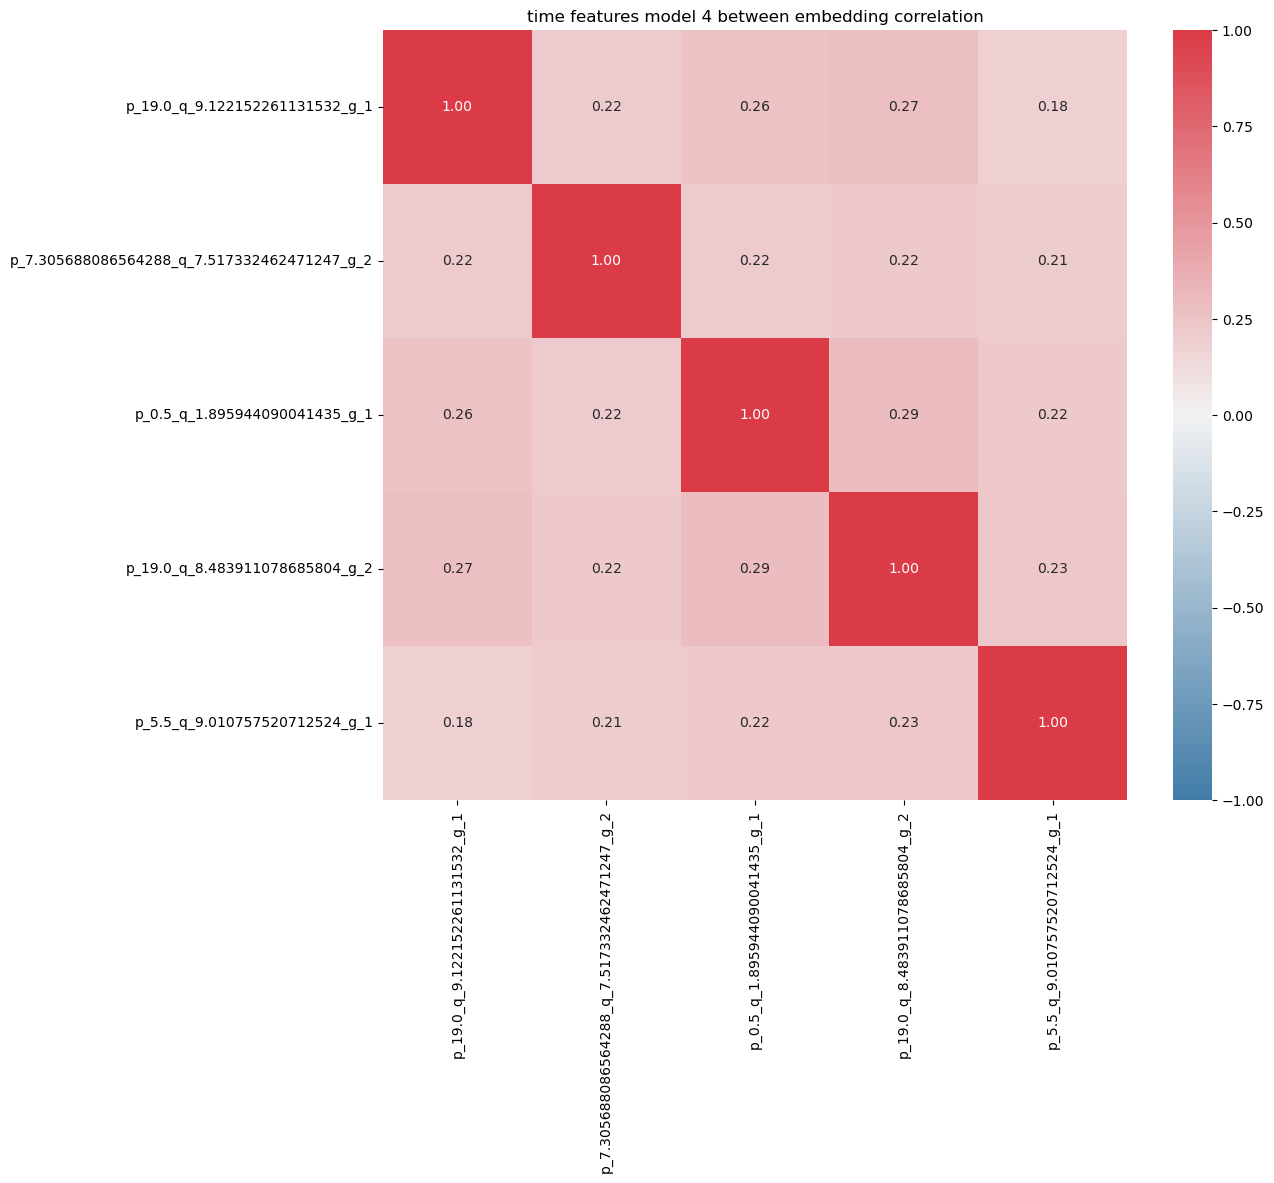

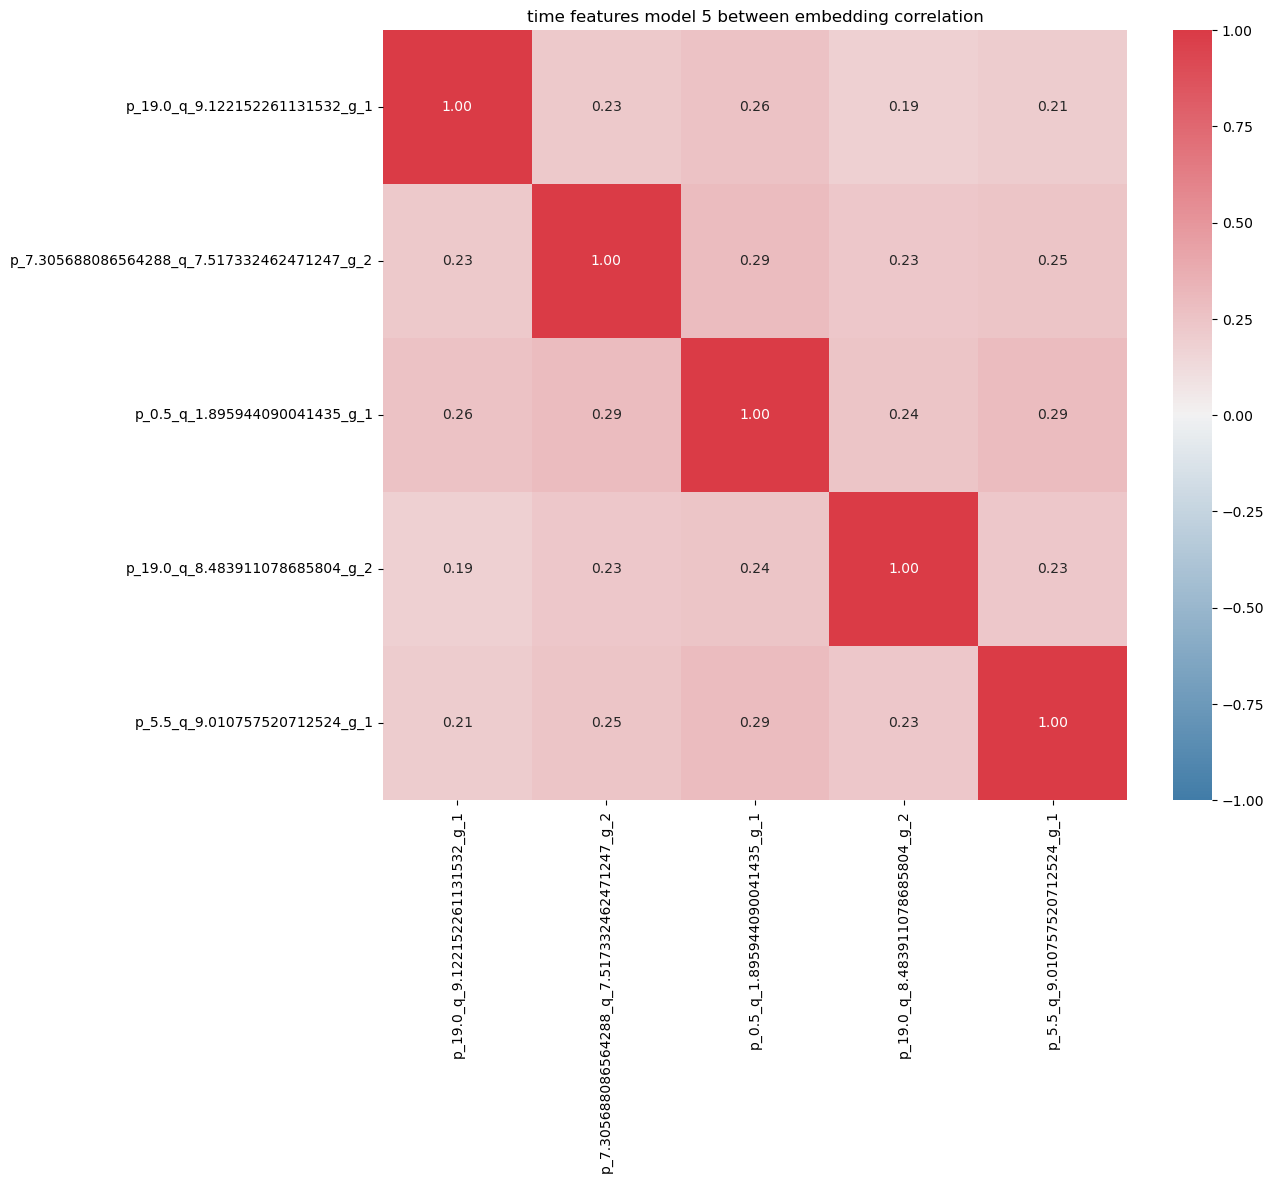

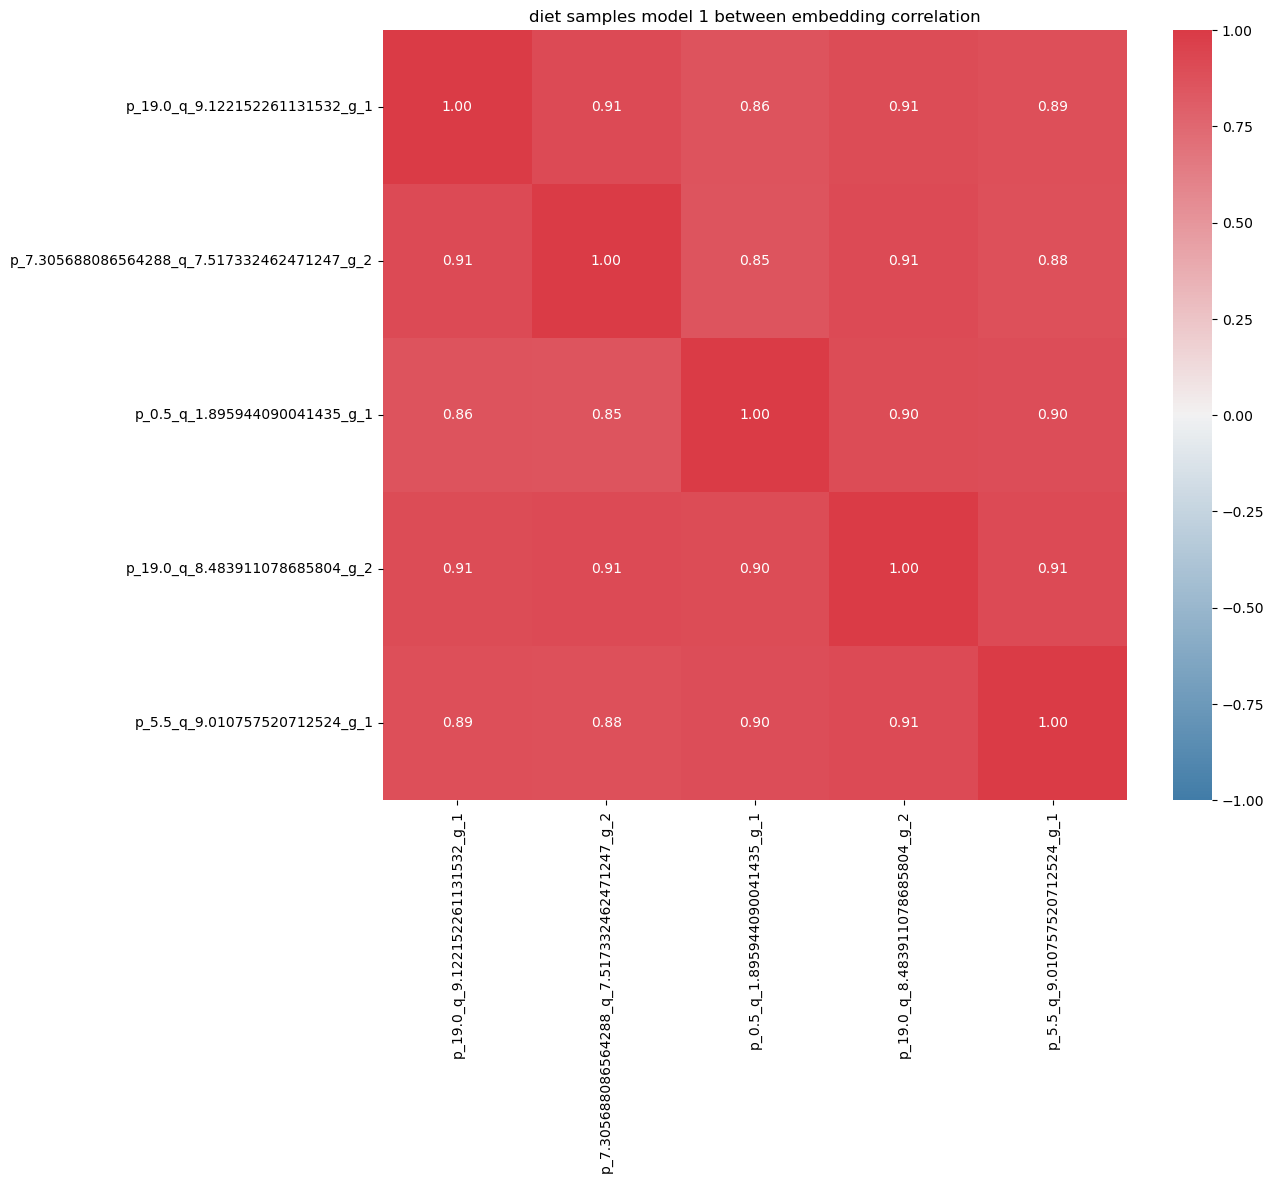

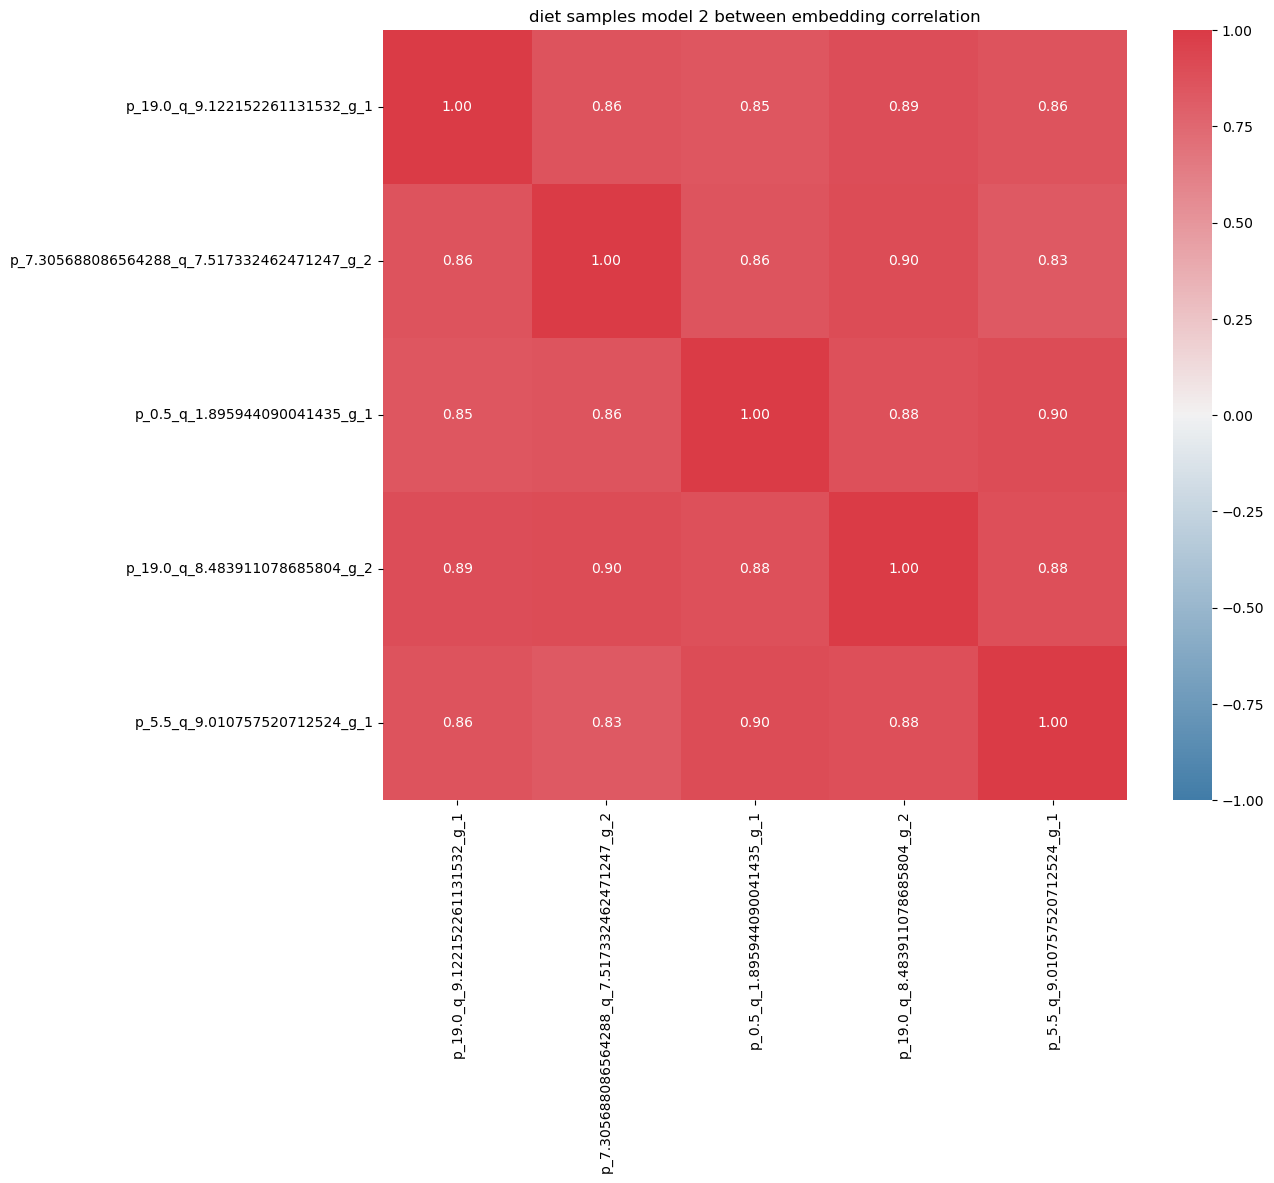

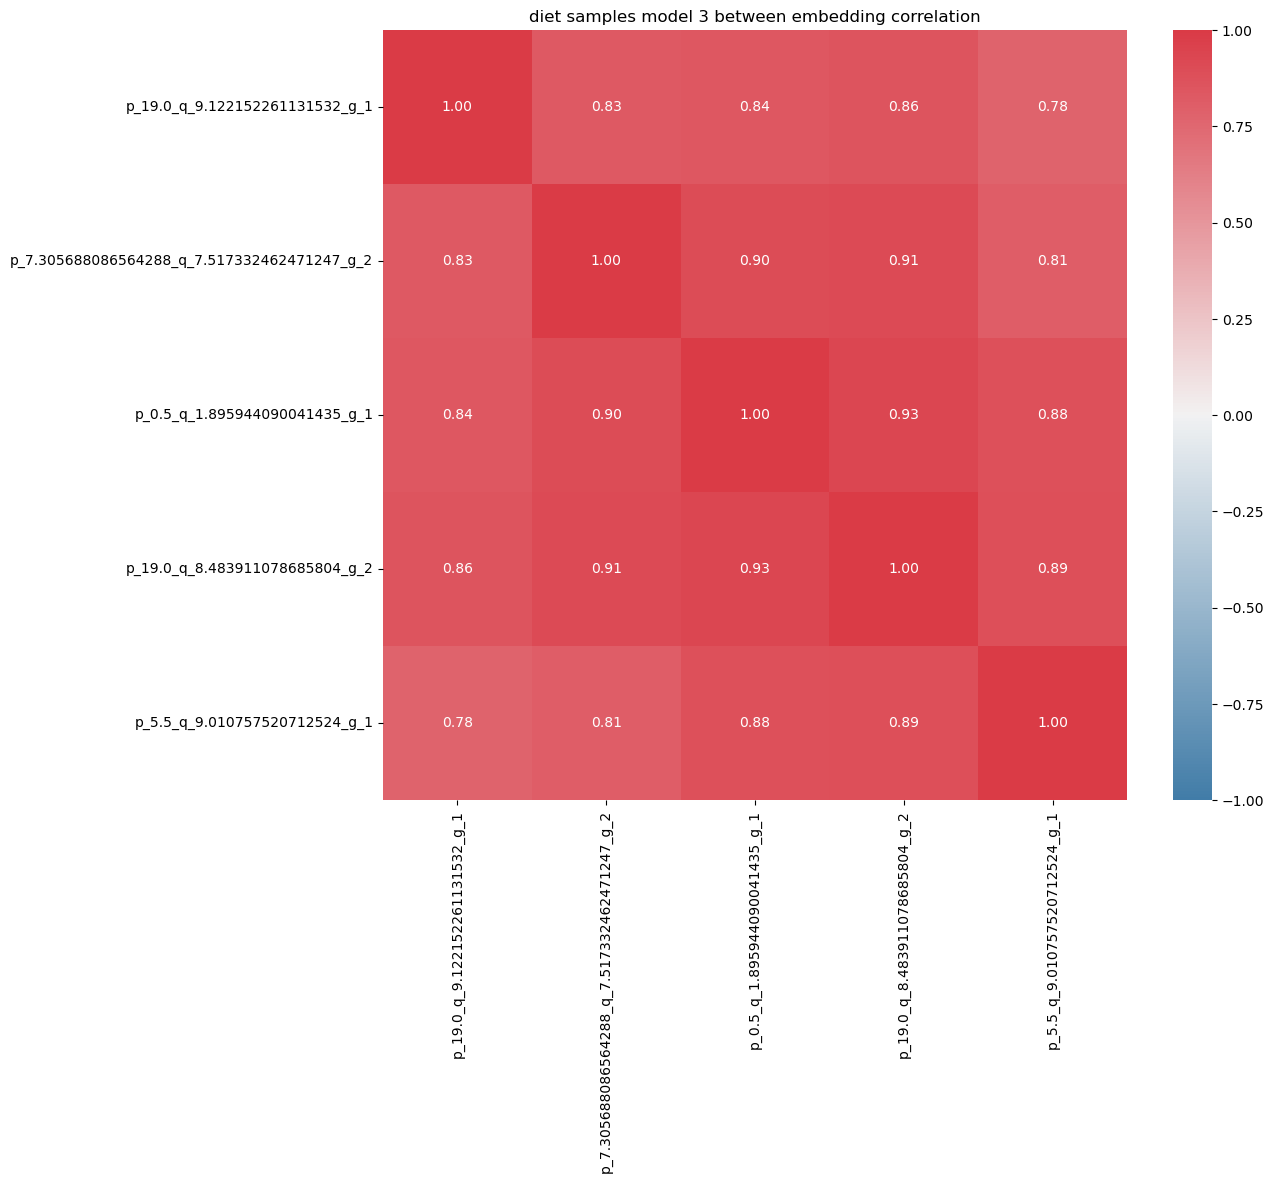

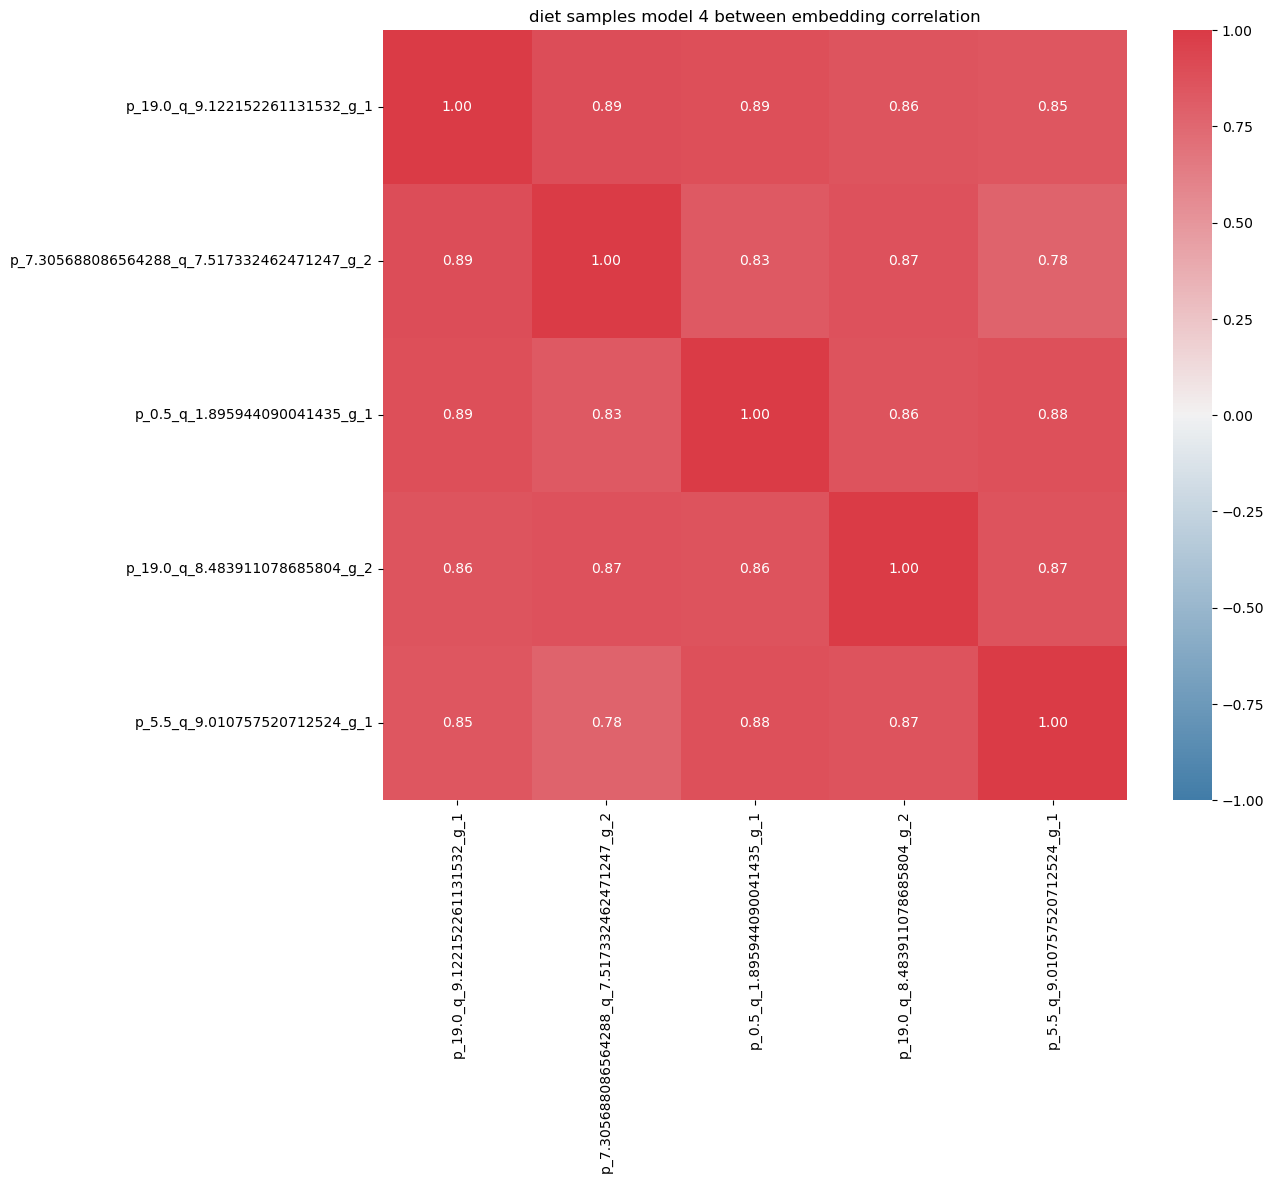

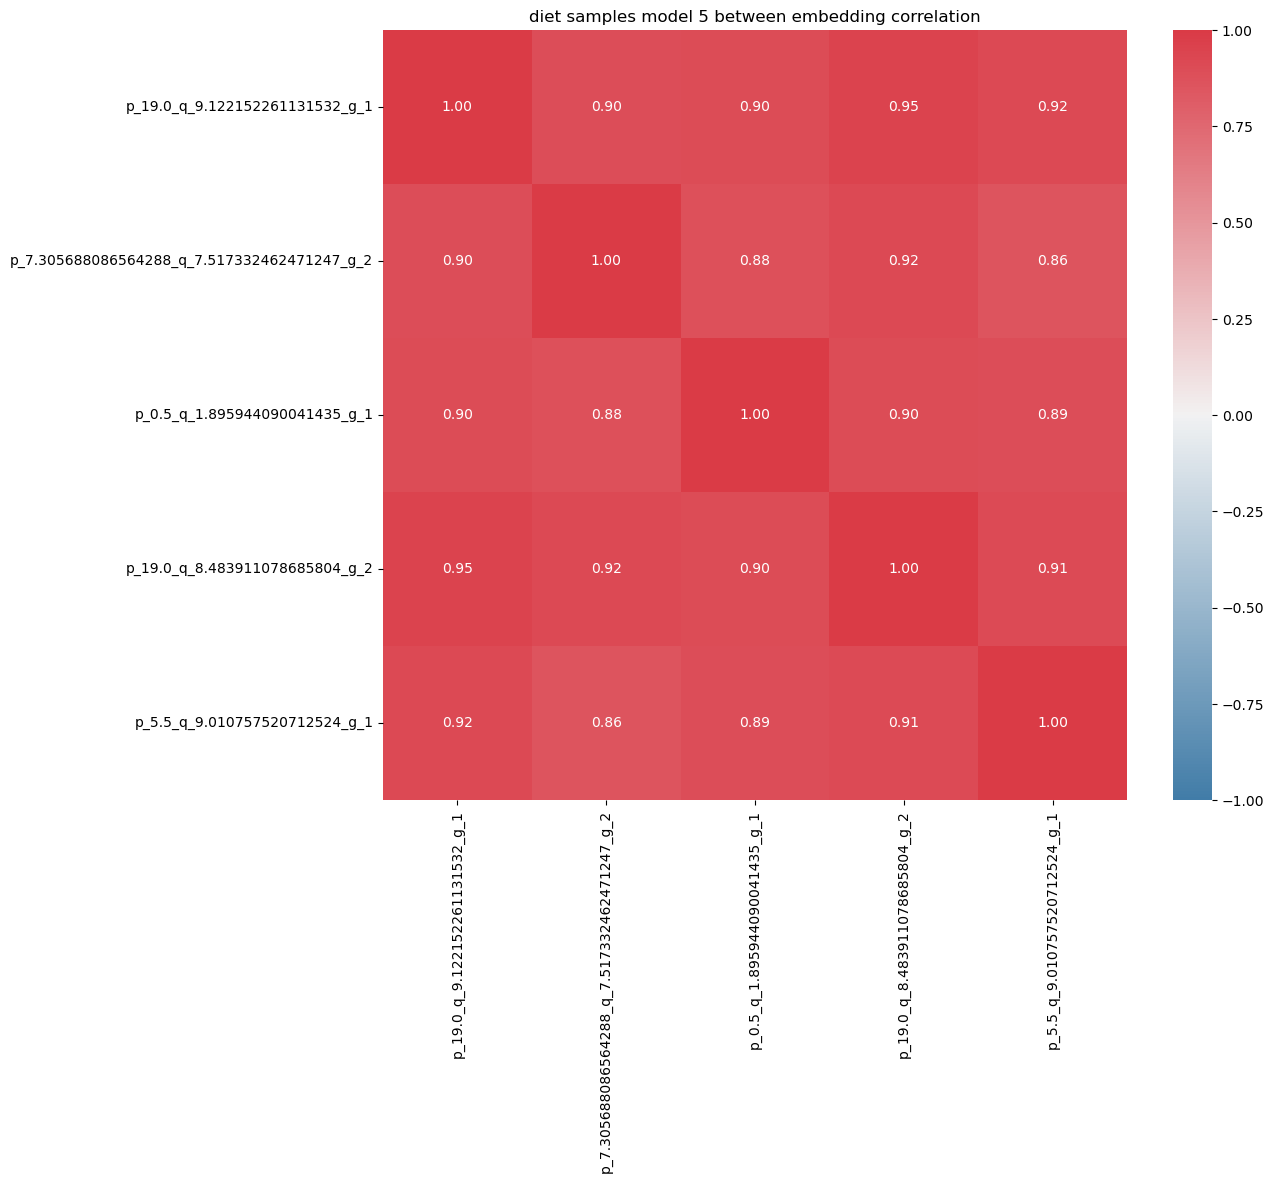

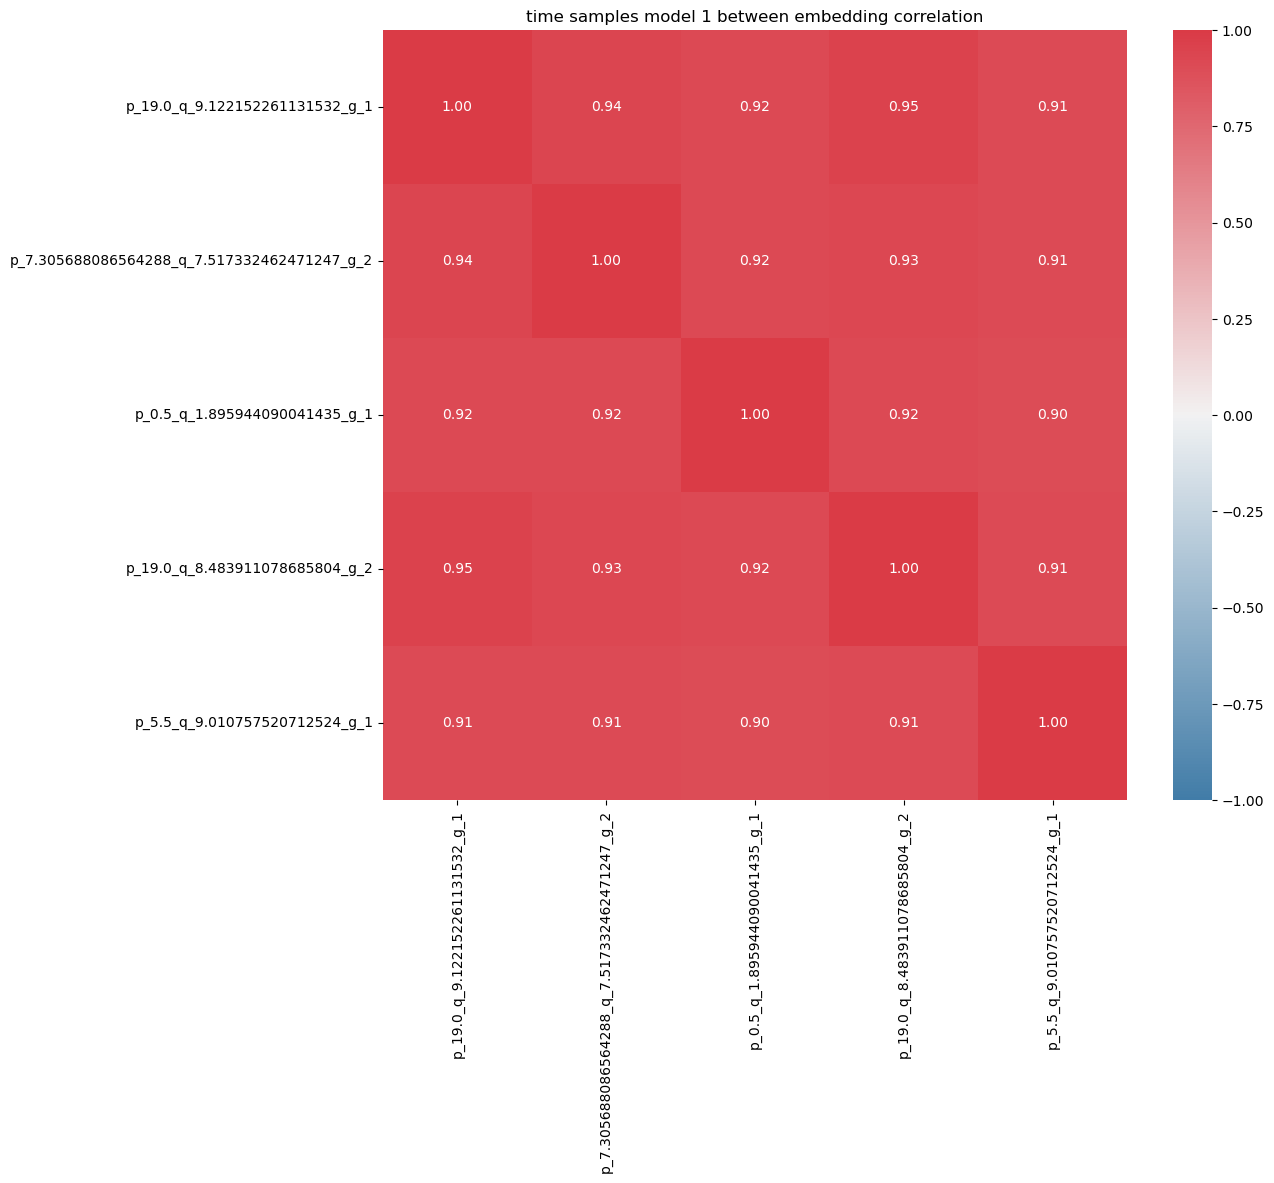

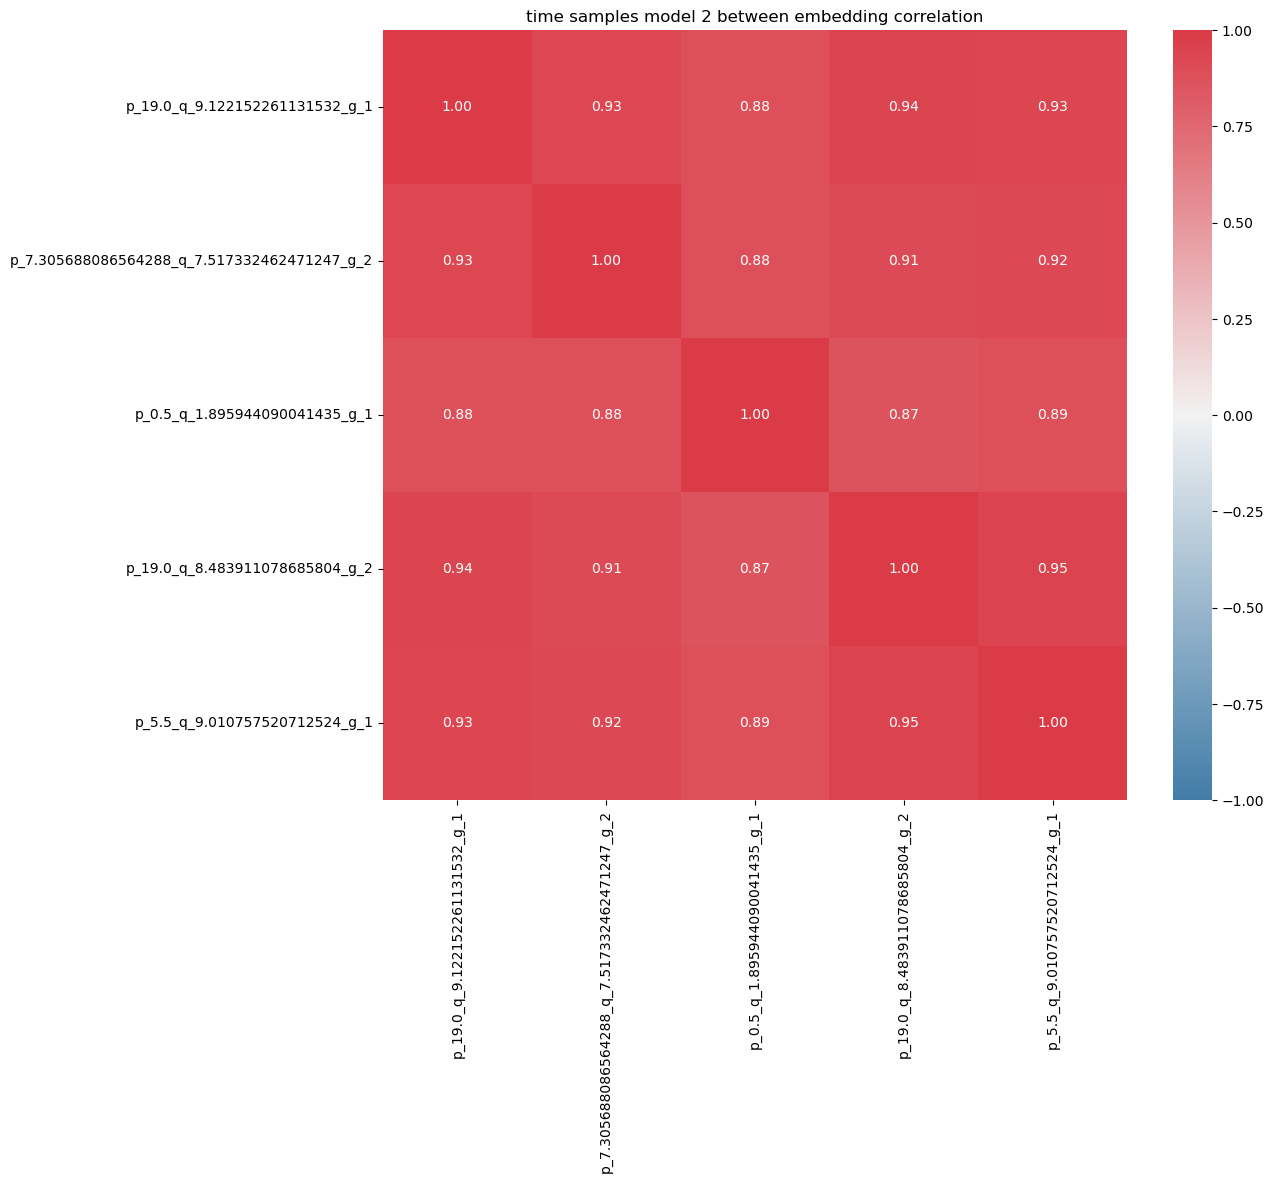

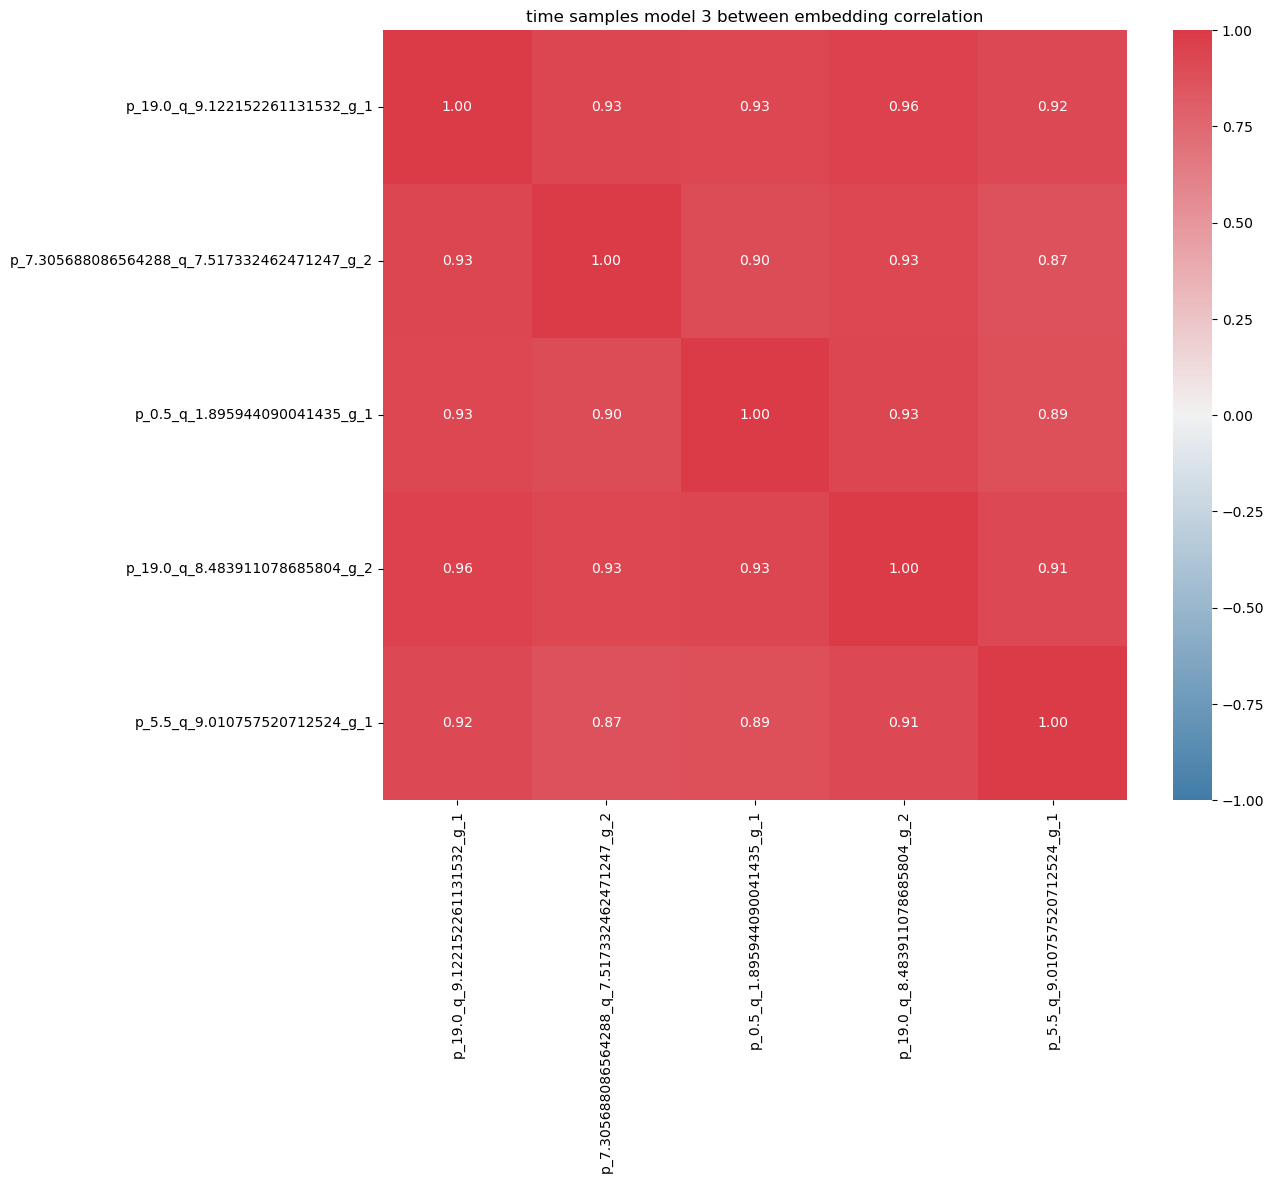

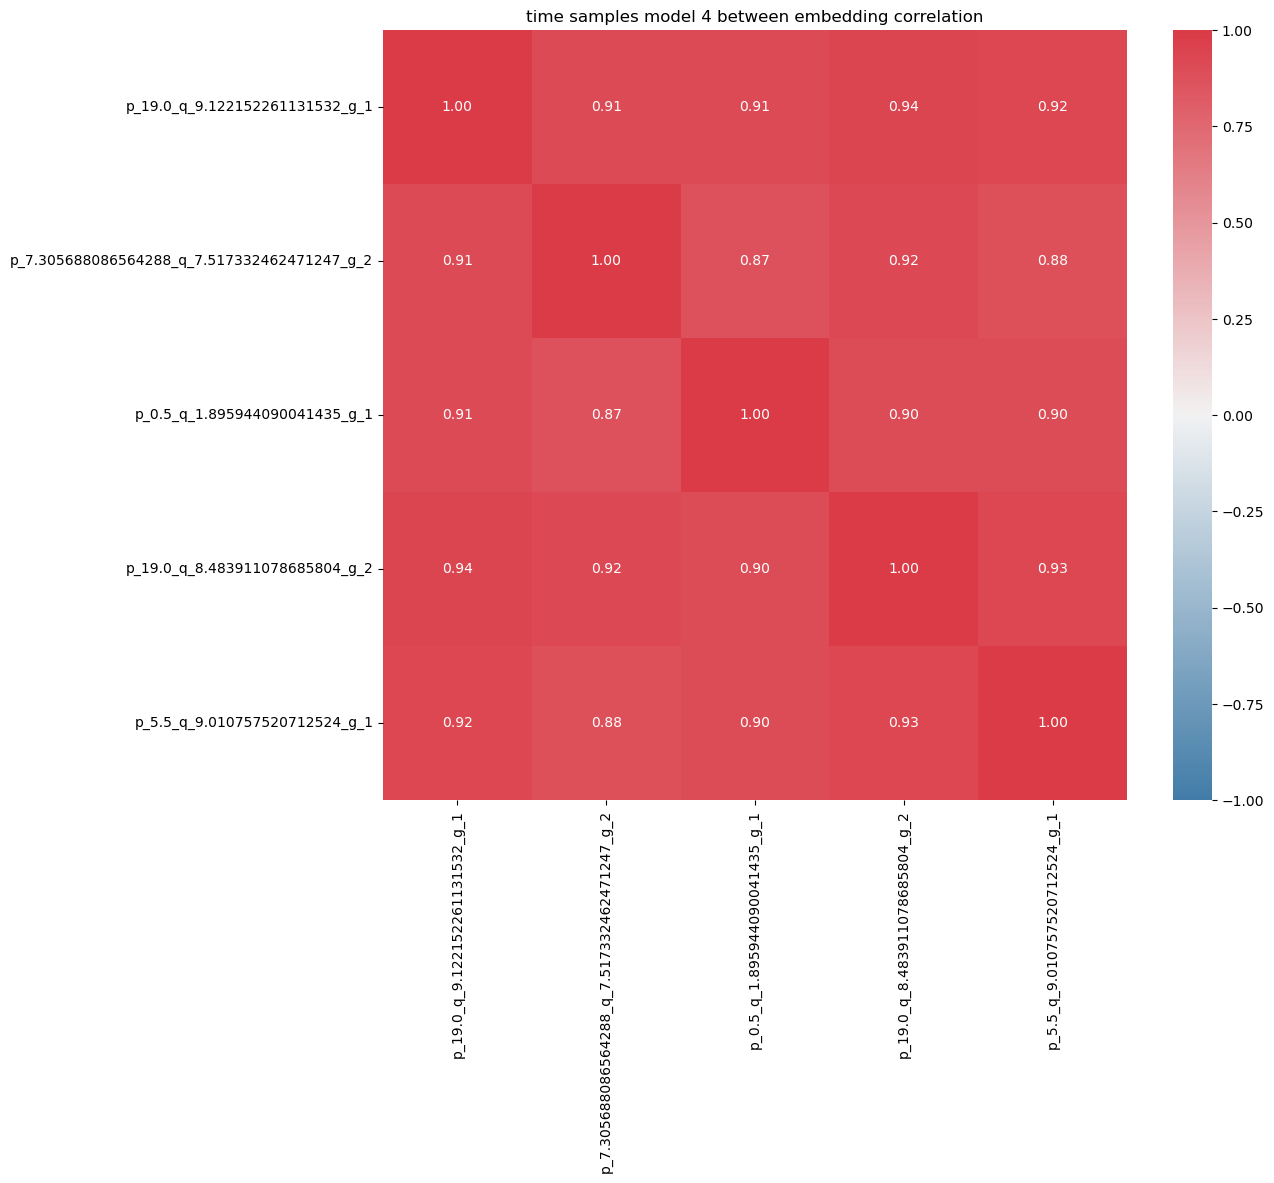

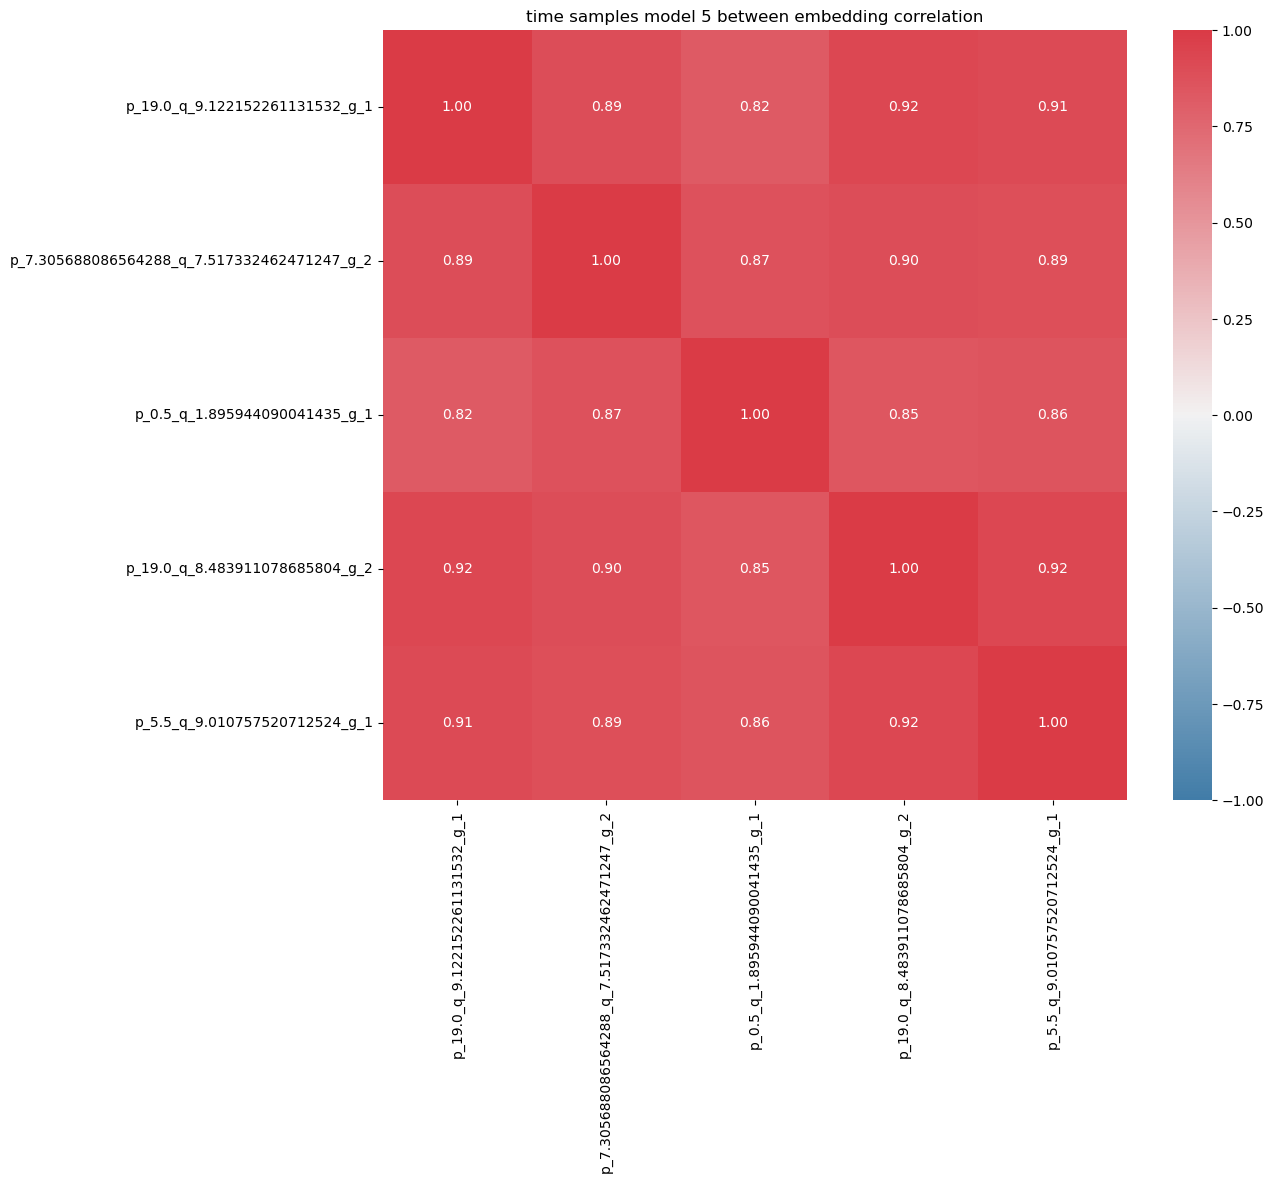

In [6]:
def get_model_correlation(predictions, classifier_type, data_type):
    model_corrs = {}
    for model in range(1,6):
        preds = []
        for params in predictions.keys():
            preds.append(predictions[params][model])
        preds = pd.DataFrame(preds, index=predictions.keys()).T
        correlation_matrix = preds.corr(method='spearman')
        p_vals = pd.DataFrame([(col1, col2, get_p_val(preds, col1, col2)) 
                       for col1 in preds.columns for col2 in preds.columns], 
                      columns=['emb_1', 'emb_2', 'p_value'])
        p_vals = p_vals.pivot(index='emb_1', columns='emb_2', values='p_value')
        p_vals.to_csv(f'../results/correlations/{classifier_type}_{data_type}_model_{model}_p_vals.tsv', sep='\t')
        make_heatmap(correlation_matrix, classifier_type, data_type, f'model {model} between embedding correlation')
        #correlation_matrix.to_csv(f'../results/correlations/{classifier_type}_{data_type}_model_{model}.tsv', sep='\t')
        corrs = np.triu(correlation_matrix, k=1)
        corrs = corrs[corrs > 0].flatten()
        model_corrs[model] = np.mean(corrs)
    return model_corrs

diet_features_model_corr = get_model_correlation(diet_features, 'diet', 'features')
time_features_model_corr = get_model_correlation(time_features, 'time', 'features')
diet_samples_model_corr = get_model_correlation(diet_samples, 'diet', 'samples')
time_samples_model_corr = get_model_correlation(time_samples, 'time', 'samples')
diet_features_model_corr, time_features_model_corr, diet_samples_model_corr, time_samples_model_corr

In [7]:
sample_models = pd.DataFrame({'diet': diet_samples_model_corr, 'time': time_samples_model_corr })
feature_models = pd.DataFrame({'diet': diet_features_model_corr, 'time': time_features_model_corr })
samples_avg = pd.DataFrame({'diet': diet_samples_avg_corr, 'time': time_samples_avg_corr })
features_avg = pd.DataFrame({'diet': diet_features_avg_corr, 'time': time_features_avg_corr })
sample_models, feature_models, samples_avg, features_avg

(       diet      time
 1  0.892547  0.921289
 2  0.872432  0.909639
 3  0.862204  0.917460
 4  0.857551  0.908081
 5  0.902203  0.882650,
        diet      time
 1  0.098594  0.209626
 2  0.088729  0.261643
 3  0.132331  0.197933
 4  0.121578  0.231481
 5  0.092028  0.241007,
                                                         diet      time
 p_19.0_q_9.122152261131532_g_1+p_7.305688086564...  0.893196  0.944519
 p_19.0_q_9.122152261131532_g_1+p_0.5_q_1.895944...  0.892598  0.910379
 p_19.0_q_9.122152261131532_g_1+p_19.0_q_8.48391...  0.903014  0.950588
 p_19.0_q_9.122152261131532_g_1+p_5.5_q_9.010757...  0.861863  0.940830
 p_7.305688086564288_q_7.517332462471247_g_2+p_0...  0.883975  0.911704
 p_7.305688086564288_q_7.517332462471247_g_2+p_1...  0.914539  0.934047
 p_7.305688086564288_q_7.517332462471247_g_2+p_5...  0.833604  0.925104
 p_0.5_q_1.895944090041435_g_1+p_19.0_q_8.483911...  0.912490  0.914938
 p_0.5_q_1.895944090041435_g_1+p_5.5_q_9.0107575...  0.889781  0.923214
 p